In [59]:
from matplotlib import pyplot as plt

import os
os.chdir('/engram/nklab/hossein/recurrent_models/transformer_brain_encoder/')
!pwd

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from engine import evaluate, train_one_epoch
from tqdm import tqdm
from scipy.stats import pearsonr as corr
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.linear_model import LinearRegression

from datasets.nsd_utils import roi_maps

data_dir = '/engram/nklab/algonauts/algonauts_2023_challenge_data/'

/engram/nklab/hossein/recurrent_models/transformer_brain_encoder


In [60]:

def corr_measure(data_dir, lh_fmri_test, rh_fmri_test, lh_fmri_pred, rh_fmri_pred):
    
    roi_name_maps, lh_challenge_rois, rh_challenge_rois = roi_maps(data_dir)
    # Empty correlation array of shape: (LH vertices)
    lh_correlation = np.zeros(lh_fmri_pred.shape[1])
    # Correlate each predicted LH vertex with the corresponding ground truth vertex
    for v in tqdm(range(lh_fmri_pred.shape[1])):
        lh_correlation[v] = corr(lh_fmri_pred[:,v], lh_fmri_test[:,v])[0]

    # Empty correlation array of shape: (RH vertices)
    rh_correlation = np.zeros(rh_fmri_pred.shape[1])
    # Correlate each predicted RH vertex with the corresponding ground truth vertex
    for v in tqdm(range(rh_fmri_pred.shape[1])):
        rh_correlation[v] = corr(rh_fmri_pred[:,v], rh_fmri_test[:,v])[0]

    return lh_correlation, rh_correlation

In [51]:

def evaluate_model(args):

    lh_corr = []
    rh_corr = []

    for subj in args.subjects:
        print(f'subj: {subj}')
        # class argObj:
        #     def __init__(self, data_dir, subj):

        args.subj = format(subj, '02')
        args.data_dir = os.path.join(data_dir, 'subj'+args.subj)


        roi_name_maps, lh_challenge_rois, rh_challenge_rois = roi_maps(args.data_dir)

        if args.split == 'val':
        
            lh_pred = []
            rh_pred = []
            lh_correlation = []
            rh_correlation = []

            lay_res_dir = f'./results/nsd_test/{args.arch}/subj_{args.subj}/{args.readout_res}/enc_{args.enc_output_layer}/'
            
            for run in args.runs:
                
                subj_res_dir = lay_res_dir + f'/run_{run}/'
                if args.verbose:
                    print(f'run: {run}')
                    print(subj_res_dir)
                
                idxs = np.load(subj_res_dir + '/idxs.npy')  

                num_train = int(np.round(len(idxs) / 100 * 90))
                idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]

                fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
                lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
                rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

                lh_fmri_train = lh_fmri[idxs_train]
                lh_fmri_val = lh_fmri[idxs_val]
                rh_fmri_train = rh_fmri[idxs_train]
                rh_fmri_val = rh_fmri[idxs_val]

                lh_fmri_pred = np.load(subj_res_dir + 'lh_fmri_val_pred.npy')
                rh_fmri_pred = np.load(subj_res_dir + 'rh_fmri_val_pred.npy')

                lh_correlation_run, rh_correlation_run = corr_measure(args.data_dir, lh_fmri_val, rh_fmri_val, lh_fmri_pred, rh_fmri_pred)
                
                if args.save_val_corr:
                    print(lay_res_dir)
                    np.save(subj_res_dir + 'lh_val_corr.npy', lh_correlation_run)
                    np.save(subj_res_dir + 'rh_val_corr.npy', rh_correlation_run)
                
                lh_correlation.append(lh_correlation_run)
                rh_correlation.append(rh_correlation_run)

            lh_correlation = np.mean(np.array(lh_correlation), axis=0)
            rh_correlation = np.mean(np.array(rh_correlation), axis=0)

            if args.save_ave:
                print(lay_res_dir)
                np.save(lay_res_dir + 'lh_val_corr.npy', lh_correlation)
                np.save(lay_res_dir + 'rh_val_corr.npy', rh_correlation)

        elif args.split == 'test':
            fmri_dir = os.path.join(args.data_dir, 'test_split', 'test_fmri')
            lh_fmri_test = np.load(os.path.join(fmri_dir, 'lh_test_fmri.npy'))
            rh_fmri_test = np.load(os.path.join(fmri_dir, 'rh_test_fmri.npy'))

            lh_pred = []
            rh_pred = []
            for run in args.runs:
                
                lay_res_dir =  f'./results/nsd_test/{args.arch}/subj_{args.subj}/{args.readout_res}/enc_{args.enc_output_layer}/'
                
                subj_res_dir = lay_res_dir + f'run_{run}/'
            
                if args.verbose:
                    print(f'run: {run}')
                    print(subj_res_dir)
                    
                if args.learn_reg:
                    feature_dir = './saved_image_features/'
                        
                    subject_feature_dir =  os.path.join(feature_dir, args.feature_name,format(subj, '02'))
                    save_dir = subject_feature_dir + '/pca_run' + str(run)
                    idxs = np.load(save_dir + '/idxs.npy') 
                    num_train = int(np.round(len(idxs) / 100 * 90))
                    idxs_train, idxs_val = idxs[:num_train], idxs[num_train:] 

                    features_train = np.load(save_dir + '/train.npy')
                    features_val = np.load(save_dir + '/val.npy')
                    features_test = np.load(save_dir + '/test.npy')

                    fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
                    lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
                    rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

                    lh_fmri_train = lh_fmri[idxs_train]
                    lh_fmri_val = lh_fmri[idxs_val]
                    rh_fmri_train = rh_fmri[idxs_train]
                    rh_fmri_val = rh_fmri[idxs_val]

                    # Fit linear regressions on the training data
                    reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
                    reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
                    # Use fitted linear regressions to predict the validation and test fMRI data
                    lh_fmri_val_pred = reg_lh.predict(features_val)
                    lh_fmri_test_pred = reg_lh.predict(features_test)
                    rh_fmri_val_pred = reg_rh.predict(features_val)
                    rh_fmri_test_pred = reg_rh.predict(features_test)

                    lh_pred.append(lh_fmri_test_pred)
                    rh_pred.append(rh_fmri_test_pred)

                else:
                    lh_pred.append(np.load(subj_res_dir + 'lh_pred_test.npy'))
                    rh_pred.append(np.load(subj_res_dir + 'rh_pred_test.npy'))
            
            lh_fmri_pred = np.mean(lh_pred, axis=0)
            rh_fmri_pred = np.mean(rh_pred, axis=0)

            if args.save_ave:
                np.save(lay_res_dir + 'lh_pred_test.npy', lh_fmri_pred)
                np.save(lay_res_dir + 'rh_pred_test.npy', rh_fmri_pred)

            fmri_noise_dir = os.path.join(args.data_dir, 'test_split', 'noise_ceiling')
            lh_nc = np.load(os.path.join(fmri_noise_dir, 'lh_noise_ceiling.npy'))
            rh_nc = np.load(os.path.join(fmri_noise_dir, 'rh_noise_ceiling.npy'))

            lh_correlation, rh_correlation = corr_measure(args.data_dir, lh_fmri_test, rh_fmri_test, lh_fmri_pred, rh_fmri_pred)

        lh_correlation[lh_correlation<0] = 0
        rh_correlation[rh_correlation<0] = 0

        if args.split == 'test' and args.measure == 'exp_var':
            lh_r2 = lh_correlation ** 2
            rh_r2 = rh_correlation ** 2

            lh_nc[lh_nc==0] = 1e-14
            rh_nc[rh_nc==0] = 1e-14

            # Compute the noise-ceiling-normalized encoding accuracy
            expl_var_lh = np.divide(lh_r2, lh_nc)
            expl_var_rh = np.divide(rh_r2, rh_nc)

            # Set the noise-ceiling-normalized encoding accuracy to 1 for those vertices
            # in which the r2 scores are higher than the noise ceiling, to prevent
            # encoding accuracy values higher than 100%
            expl_var_lh[expl_var_lh>1] = 1
            expl_var_rh[expl_var_rh>1] = 1

            lh_correlation = expl_var_lh
            rh_correlation = expl_var_rh
        
        # Select the correlation results vertices of each ROI
        roi_names = []
        lh_roi_correlation = []
        rh_roi_correlation = []
        for r1 in range(len(lh_challenge_rois)):
            for r2 in roi_name_maps[r1].items():
                if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
                    roi_names.append(r2[1])
                    lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
                    rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
                    lh_roi_correlation.append(lh_correlation[lh_roi_idx])
                    rh_roi_correlation.append(rh_correlation[rh_roi_idx])
        roi_names.append('All vertices')
        lh_roi_correlation.append(lh_correlation)
        rh_roi_correlation.append(rh_correlation)


        # Create the plot
        lh_mean_roi_correlation = [np.mean(np.nan_to_num(np.array(lh_roi_correlation[r]), copy=True, nan=0.0, posinf=None, neginf=None))
            for r in range(len(lh_roi_correlation))]
        rh_mean_roi_correlation = [np.mean(np.nan_to_num(np.array(rh_roi_correlation[r]), copy=True, nan=0.0, posinf=None, neginf=None))
            for r in range(len(rh_roi_correlation))]

        plt.rcParams.update({'font.size': 18})

        if args.plot_figs:
            fig = plt.figure(figsize=(18,6))
            x = np.arange(len(roi_names))
            width = 0.30
            plt.bar(x - width/2, lh_mean_roi_correlation, width, label='Left Hemisphere')
            plt.bar(x + width/2, rh_mean_roi_correlation, width,
                label='Right Hemishpere')
            plt.xlim(left=min(x)-.5, right=max(x)+.5)
            plt.ylim(bottom=0, top=1)
            plt.xlabel('ROIs')
            plt.xticks(ticks=x, labels=roi_names, rotation=75)
            plt.ylabel('Mean Pearson\'s $r$')
            plt.legend(frameon=True, loc=1);
            plt.show()
            
            #fig.savefig('figures/detr_dino_8_visuals_16.pdf', format='pdf', bbox_inches="tight")
            #fig.savefig('figures/detr_dino_1_streams_inc_16.jpg', dpi=300, bbox_inches="tight")

        lh_corr.append(lh_mean_roi_correlation[-1])
        rh_corr.append(rh_mean_roi_correlation[-1])

        if args.verbose:
            print(f'subj: {subj}   lh_corr: {lh_mean_roi_correlation[-1]}   rh_corr: {rh_mean_roi_correlation[-1]}')

    if args.verbose:
        print(f'lh_corr_mean: {np.array(lh_corr).mean()}   rh_corr_mean: {np.array(rh_corr).mean()}')

    return lh_corr, rh_corr, lh_correlation, rh_correlation

subj: 7
run: 1
./results/nsd_test/dinov2_q_transformer/subj_07/rois_all/enc_1//run_1/


100%|██████████| 20544/20544 [00:13<00:00, 1546.65it/s]


run: 2
./results/nsd_test/dinov2_q_transformer/subj_07/rois_all/enc_1//run_2/


100%|██████████| 20544/20544 [00:13<00:00, 1548.08it/s]


run: 3
./results/nsd_test/dinov2_q_transformer/subj_07/rois_all/enc_1//run_3/


100%|██████████| 20544/20544 [00:13<00:00, 1560.45it/s]


run: 4
./results/nsd_test/dinov2_q_transformer/subj_07/rois_all/enc_1//run_4/


100%|██████████| 20544/20544 [00:13<00:00, 1566.39it/s]


run: 5
./results/nsd_test/dinov2_q_transformer/subj_07/rois_all/enc_1//run_5/


100%|██████████| 20544/20544 [00:12<00:00, 1584.75it/s]


run: 6
./results/nsd_test/dinov2_q_transformer/subj_07/rois_all/enc_1//run_6/


100%|██████████| 20544/20544 [00:13<00:00, 1571.60it/s]


run: 7
./results/nsd_test/dinov2_q_transformer/subj_07/rois_all/enc_1//run_7/


100%|██████████| 20544/20544 [00:13<00:00, 1560.49it/s]


run: 8
./results/nsd_test/dinov2_q_transformer/subj_07/rois_all/enc_1//run_8/


100%|██████████| 20544/20544 [00:13<00:00, 1548.71it/s]


run: 9
./results/nsd_test/dinov2_q_transformer/subj_07/rois_all/enc_1//run_9/


100%|██████████| 20544/20544 [00:13<00:00, 1567.37it/s]


run: 10
./results/nsd_test/dinov2_q_transformer/subj_07/rois_all/enc_1//run_10/


100%|██████████| 20544/20544 [00:13<00:00, 1572.81it/s]


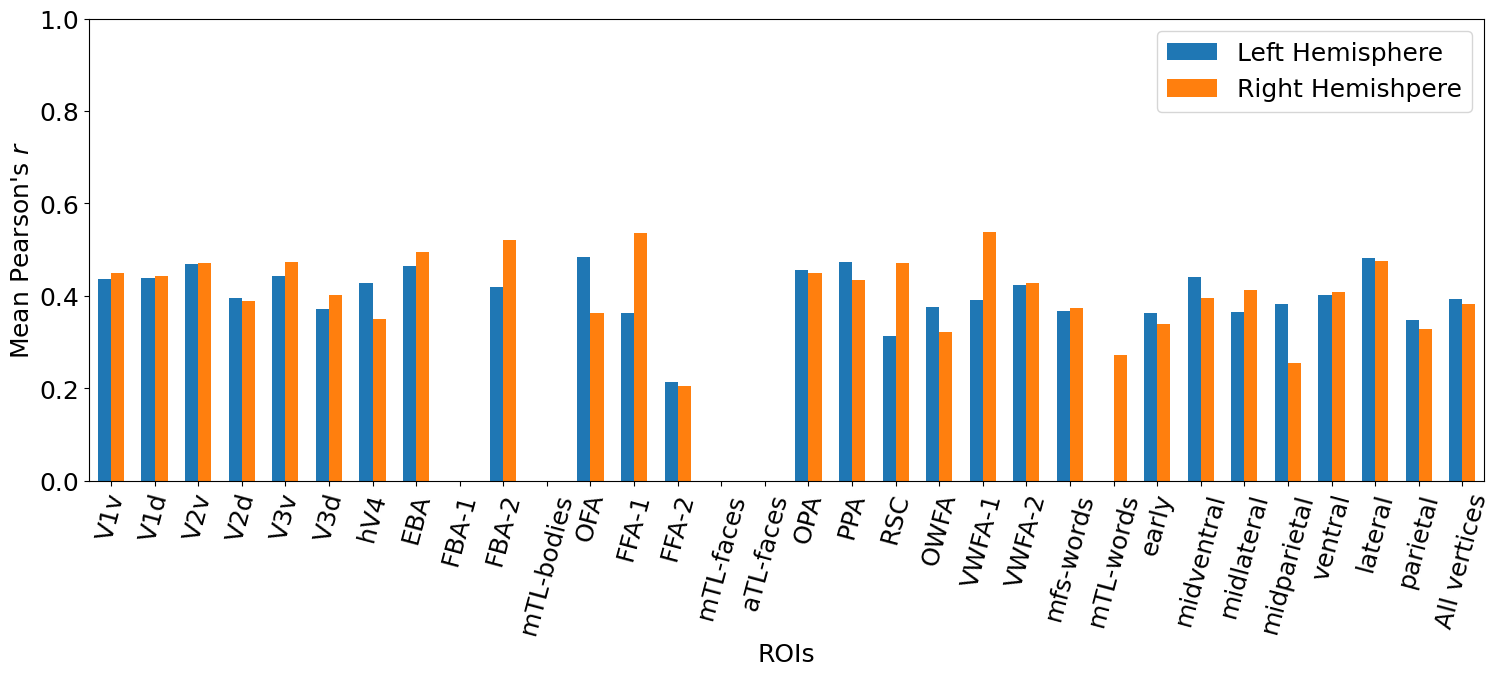

subj: 7   lh_corr: 0.3920244772115652   rh_corr: 0.38181074336100396
lh_corr_mean: 0.3920244772115652   rh_corr_mean: 0.38181074336100396


In [52]:


# arch = 'dinov2_q_transformer' #'resnet50_transformer' # dinov2_q_transformer
# feature_name = 'dinov2_q_last' # 'resnet50'  # dinov2_q_last


class model_argObj:
    def __init__(self, arch, feature_name, readout_res, enc_output_layer, learn_reg):

        self.arch = arch
        self.feature_name = feature_name
        self.readout_res = readout_res
        self.enc_output_layer = enc_output_layer
        self.learn_reg = learn_reg

        self.subjects = np.arange(7,8)
        self.runs = np.arange(1,11)

        self.split = 'val' # test
        self.measure = 'corr'  # 'exp_var' 'corr'
        self.verbose = 1
        self.plot_figs = 1

        self.save_fig = None # 'figures/detr_dino_8_visuals_16.pdf'
        self.save_mean_act = None # 'figures/detr_dino_8_visuals_16.jpg'

        self.save_ave = 0
        self.save_val_corr = 0


qargs = []
qargs.append(['dinov2_q_transformer', 'dinov2_q_last', 'rois_all', 1, 0])

# args = model_argObj(*qargs[0])
# evaluate_model(args)

# qargs.append(['dinov2_q_transformer', 'dinov2_q_last', 'voxels', 4, 0])
# qargs.append(['dinov2_q_transformer', 'dinov2_q_last', 'voxels', 6, 0])
# qargs.append(['dinov2_q_transformer', 'dinov2_q_last', 'voxels', 8, 0])
# qargs.append(['dinov2_q_transformer', 'dinov2_q_last', 'voxels', 10, 0])
# qargs.append(['dinov2_q_transformer', 'dinov2_q_last', 'voxels', 12, 0])

for m in range(len(qargs)):
    args = model_argObj(*qargs[m])
    evaluate_model(args)



# qargs.append(['dinov2_q_transformer', 'dinov2_q_last', 'streams_inc', 1, 0])
# qargs.append(['dinov2_q_regression', 'dinov2_q_last', 'streams_inc', 1, 1])
# qargs.append(['resnet50_transformer', 'resnet50', 'streams_inc', 1, 0])
# qargs.append(['resnet50_regression', 'resnet50', 'streams_inc', 1, 1])

# lh_corr_all_models = {}
# rh_corr_all_models = {}


#     lh_corr, rh_corr, lh_correlation, rh_correlation = evaluate_model(args)


#     lh_corr_all_models[args.arch] = np.array(lh_corr)
#     rh_corr_all_models[args.arch] = np.array(rh_corr)



Test on Validation set 

In [12]:
lh_corr_all_models
rh_corr_all_models

{'dinov2_q_transformer': array([0.58498089, 0.54900145, 0.59857043, 0.58511092, 0.55788661,
        0.64609867, 0.41956083, 0.63325287]),
 'dinov2_q_regression': array([0.52097164, 0.47873877, 0.47857541, 0.50011801, 0.45368871,
        0.49827777, 0.34413907, 0.48687417]),
 'resnet50_transformer': array([0.51108422, 0.48968636, 0.54685597, 0.52779384, 0.50489878,
        0.4999738 , 0.37354996, 0.57823268]),
 'resnet50_regression': array([0.47982523, 0.43287897, 0.50108837, 0.49346975, 0.43119755,
        0.47252936, 0.33265084, 0.45279168])}

In [ ]:

save_path = './results/nsd_test/lh_corr_all_models.npz'
np.savez(save_path, lh_corr_all_models)

save_path = './results/nsd_test/rh_corr_all_models.npz'
np.savez(save_path, rh_corr_all_models)


lh_corr_all_models = np.load('lh_corr_all_models.npz', allow_pickle=True)['arr_0'].item()
rh_corr_all_models = np.load('rh_corr_all_models.npz', allow_pickle=True)['arr_0'].item()
print(rh_)


import pickle


# Save to a .pkl file
# save_path = './results/nsd_test/lh_corr_all_models.pkl'
# with open(save_path, 'wb') as f:
#     pickle.dump(lh_corr_all_models, f)

# save_path = './results/nsd_test/rh_corr_all_models.pkl'
# with open(save_path, 'wb') as f:
#     pickle.dump(rh_corr_all_models, f)

# To load it back
# with open('data.pkl', 'rb') as f:
#     loaded_data = pickle.load(f)

# print(loaded_data)

In [13]:


def average_dicts(dict1, dict2):
    averaged_dict = {}
    
    # Iterate through keys in the first dictionary
    for key in dict1:
        if key in dict2:
            # Average the values if the key exists in both dictionaries
            averaged_dict[key] = (dict1[key] + dict2[key]) / 2
    
    return averaged_dict


# Average the corresponding values
averaged_result = average_dicts(lh_corr_all_models, rh_corr_all_models)
print(averaged_result)




import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests


df = pd.DataFrame(averaged_result)

# List to hold p-values
p_values = []

# Perform t-tests between all pairs of groups
groups = df.columns
for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        print(df[groups[i]]- df[groups[j]])
        t_stat, p_val = stats.ttest_rel(df[groups[i]], df[groups[j]])
        p_values.append(p_val)

# Apply Bonferroni correction
corrected_p_values = multipletests(p_values, method='bonferroni')[1]

# Print results
for index, (group1, group2) in enumerate([(groups[i], groups[j]) for i in range(len(groups)) for j in range(i + 1, len(groups))]):
    print(f'T-test between {group1} and {group2}:')
    print(f'    p-value: {p_values[index]}')
    print(f'    Corrected p-value: {corrected_p_values[index]}')

{'dinov2_q_transformer': array([0.59316975, 0.55535867, 0.60012746, 0.56260108, 0.56434735,
       0.64502246, 0.42276202, 0.62444349]), 'dinov2_q_regression': array([0.52443175, 0.47510317, 0.47429982, 0.47519044, 0.45702892,
       0.49409076, 0.3389616 , 0.47619074]), 'resnet50_transformer': array([0.51863325, 0.49843867, 0.55374626, 0.49267968, 0.50467828,
       0.50776981, 0.38090322, 0.56782887]), 'resnet50_regression': array([0.47727456, 0.43796127, 0.50119808, 0.46015892, 0.43037899,
       0.46604763, 0.33656899, 0.44646885])}
0    0.068738
1    0.080256
2    0.125828
3    0.087411
4    0.107318
5    0.150932
6    0.083800
7    0.148253
dtype: float64
0    0.074537
1    0.056920
2    0.046381
3    0.069921
4    0.059669
5    0.137253
6    0.041859
7    0.056615
dtype: float64
0    0.115895
1    0.117397
2    0.098929
3    0.102442
4    0.133968
5    0.178975
6    0.086193
7    0.177975
dtype: float64
0    0.005798
1   -0.023335
2   -0.079446
3   -0.017489
4   -0.047649
5   -0

In [28]:
averaged_result.shape

AttributeError: 'dict' object has no attribute 'shape'

In [29]:
result = np.array(list(averaged_result.values()))
result

array([[0.59316975, 0.55535867, 0.60012746, 0.56260108, 0.56434735,
        0.64502246, 0.42276202, 0.62444349],
       [0.52443175, 0.47510317, 0.47429982, 0.47519044, 0.45702892,
        0.49409076, 0.3389616 , 0.47619074],
       [0.51863325, 0.49843867, 0.55374626, 0.49267968, 0.50467828,
        0.50776981, 0.38090322, 0.56782887],
       [0.47727456, 0.43796127, 0.50119808, 0.46015892, 0.43037899,
        0.46604763, 0.33656899, 0.44646885]])

In [ ]:
def plt_summ(summ_rts, ylim):
    
    fig = plt.figure(figsize=(4, 4))

    labels = ['Same', 'Different']
    close_means = summ_rts[0:2,0]
    close_ses = summ_rts[0:2,1]

    far_means = summ_rts[2:4,0]
    far_ses = summ_rts[2:4,1]


    x =np.array([0, 1.5])  # the label locations
    width = 0.5  # the width of the bars

    plt.rcParams.update({'font.size': 18})

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, close_means, width, label='Close', edgecolor = 'black', color = ['lightgreen', 'lightblue'], yerr=close_ses, capsize=3)

    rects2 = ax.bar(x + width/2, far_means, width, label='Far', edgecolor = 'black', color =['green', 'steelblue'], yerr=far_ses, capsize=3)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Reaction time (ms)')
    ax.set_title('')
    ax.set_xticks(x)  # , labels=labels
    ax.set_xticklabels(labels)
    #ax.legend() 
    ax.set_ylim(ylim) #(35, 60)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # ax.bar_label(rects1, padding=3)
    # ax.bar_label(rects2, padding=3)

    plt.tight_layout()
    plt.show()
    
    fig.savefig("figures/humans_rt.svg", bbox_inches='tight', dpi=300)

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (4).

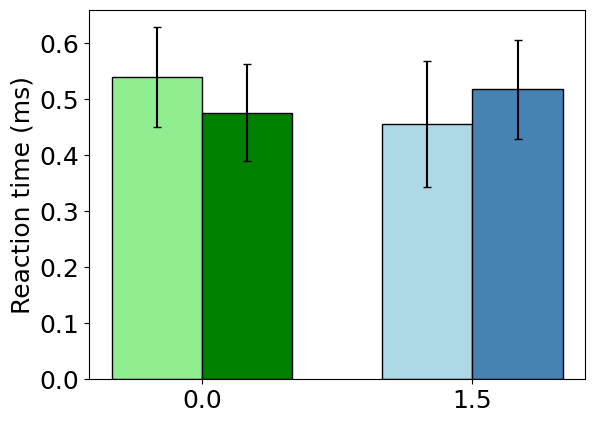

In [21]:
# Sample data for four groups (two groups of two)


# Combine data into a 2D array
data = result

# Calculate means and SEM
means = np.mean(data, axis=1)
sem = np.std(data, axis=1) / np.sqrt(data.shape[1])  # Standard error of the mean  

x =np.array([0, 1.5])  # the label locations
width = 0.5  # the width of the bars

plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, means[:2], width, label='Close', edgecolor = 'black', color = ['lightgreen', 'lightblue'], yerr=sem[:2], capsize=3)

rects2 = ax.bar(x + width/2, means[2:], width, label='Far', edgecolor = 'black', color =['green', 'steelblue'], yerr=sem[2:], capsize=3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Reaction time (ms)')
ax.set_title('')
ax.set_xticks(x)  # , labels=labels
ax.set_xticklabels(['Group 1', 'Group 1', 'Group 2', 'Group 2'])
#ax.legend() 
ax.set_ylim(ylim) #(35, 60)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

plt.tight_layout()
plt.show()

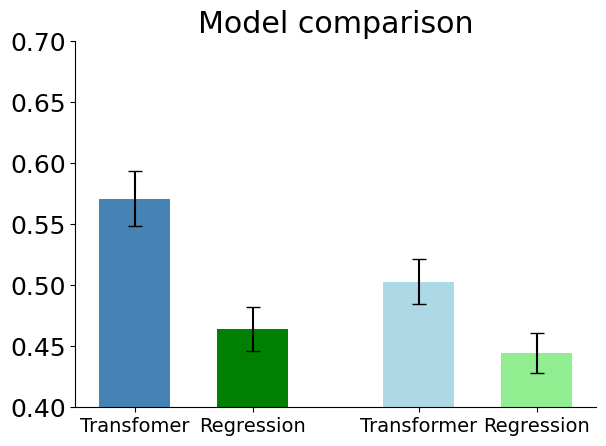

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Combine data into a 2D array
data = result

# Calculate means and SEM
means = np.mean(data, axis=1)
sem = np.std(data, axis=1) / np.sqrt(data.shape[1]) 

# Set bar positions
x = np.arange(len(means))  # the label locations
width = 0.6  # reduced width of the bars
sep = 0.2  # separation between the groups

# Create a bar plot
fig, ax = plt.subplots()

# Adjust the positions of bars for each group to be closer
bars1 = ax.bar(x[:2] - sep, means[:2], width, label='Group 1', color = ['steelblue', 'green'], yerr=sem[:2], capsize=5)
bars2 = ax.bar(x[2:4] + sep, means[2:4], width, label='Group 2', color = ['lightblue', 'lightgreen'], yerr=sem[2:4], capsize=5)

# Set the position of ticks and labels
#ax.set_ylabel('Explained variance (%)')
ax.set_title('Model comparison')
ax.set_xticks([0 - sep, 1 - sep, 2+sep, 3+sep])
plt.xticks(fontsize=14)
ax.set_xticklabels(['Transfomer', 'Regression', 'Transformer', 'Regression'])
#ax.legend()
ax.set_ylim(0.4,0.7) #(35, 60)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()


## average the 10 runs for each setting of input layer - output decoder 

In [ ]:
import numpy as np
from pathlib import Path
import os


for subj in range(1,9):
    
    class argObj:
        def __init__(self, subj):
            self.subj = format(subj, '02')

    args = argObj(subj)
    
    for readout_res in ['bodies', 'places', 'faces', 'words']: 
        # ,     'streams_inc']: 'streams_inc', 'savedfeats_streams_inc', 'visuals', 
    
        if readout_res == 'streams_inc':
            selected_layers = [1,2,3,4,5,6]
        elif readout_res == 'savedfeats_streams_inc':
             selected_layers = [1]
        elif readout_res == 'visuals':
            selected_layers = [5,6,7,8,9]
        elif readout_res == 'bodies':
            selected_layers = [1,3,4]
        elif readout_res == 'places':
            selected_layers = [2,3,4]
        elif readout_res == 'faces':
            selected_layers = [4]
        elif readout_res == 'words':
            selected_layers = [3,4] 
            
    
        for lay in selected_layers: # [6]: # range(5,11): detr_dino_10_bodies_16

            subj_res_dir = f'./results/nsd_test/{args.arch}/subj_{args.subj}/{args.readout_res}/enc_{args.enc_output_layer}/run_{run}/'

            test_save_dir = '../results/detr_dino_'+ str(lay)+ '_' + readout_res + '_16/' + str(args.subj)   
            
            if not (os.path.exists(test_save_dir+ '/run10/lh_pred_test.npy')): continue 
            print(test_save_dir)

            lh_pred_test = []
            rh_pred_test = []

            lh_pred_corr = []
            rh_pred_corr = [] 

            for run in range(1,11):

                subj_res_dir = test_save_dir + '/run' + str(run) + '/'


                lh_fmri_test_pred = np.load(subj_res_dir + 'lh_pred_test.npy')
                rh_fmri_test_pred = np.load(subj_res_dir + 'rh_pred_test.npy')

                lh_pred_test.append(lh_fmri_test_pred)
                rh_pred_test.append(rh_fmri_test_pred)


                lh_roi_correlation = np.load(subj_res_dir + 'lh_roi_correlation.npy')
                rh_roi_correlation = np.load(subj_res_dir + 'rh_roi_correlation.npy')

                lh_pred_corr.append(lh_roi_correlation)
                rh_pred_corr.append(rh_roi_correlation)

 
            lh_pred_test = np.array(lh_pred_test).mean(0)
            rh_pred_test = np.array(rh_pred_test).mean(0)

            np.save(test_save_dir+'/lh_pred_test_mm10.npy', lh_pred_test)
            np.save(test_save_dir+'/rh_pred_test_mm10.npy', rh_pred_test)


            lh_pred_corr = np.array(lh_pred_corr).mean(0)
            rh_pred_corr = np.array(rh_pred_corr).mean(0)

            np.save(test_save_dir+'/lh_pred_corr_mm10.npy', lh_pred_corr)
            np.save(test_save_dir+'/rh_pred_corr_mm10.npy', rh_pred_corr)
        

        

## combine all the test predictions based on softmax 

In [61]:
class model_argObj:
    def __init__(self, arch, feature_name, readout_res, enc_output_layer, learn_reg):

        self.arch = arch
        self.feature_name = feature_name
        self.readout_res = readout_res
        self.enc_output_layer = enc_output_layer
        self.learn_reg = learn_reg

        self.subjects = np.arange(1,9)
        self.runs = np.arange(1,11)

        self.split = 'test' # test
        self.measure = 'exp_var'  # 'exp_var' 'corr'
        self.verbose = 1
        self.plot_figs = 1

        self.save_fig = None # 'figures/detr_dino_8_visuals_16.pdf'
        self.save_mean_act = None # 'figures/detr_dino_8_visuals_16.jpg'

        self.save_ave = 1


qargs = []
qargs.append(['dinov2_q_transformer', 'dinov2_q_last', 'voxels', 1, 0])
args = model_argObj(*qargs[0])


In [38]:
args.runs

array([1])

subj: 1
(6, 159, 20544)


100%|██████████| 20544/20544 [00:11<00:00, 1714.02it/s]


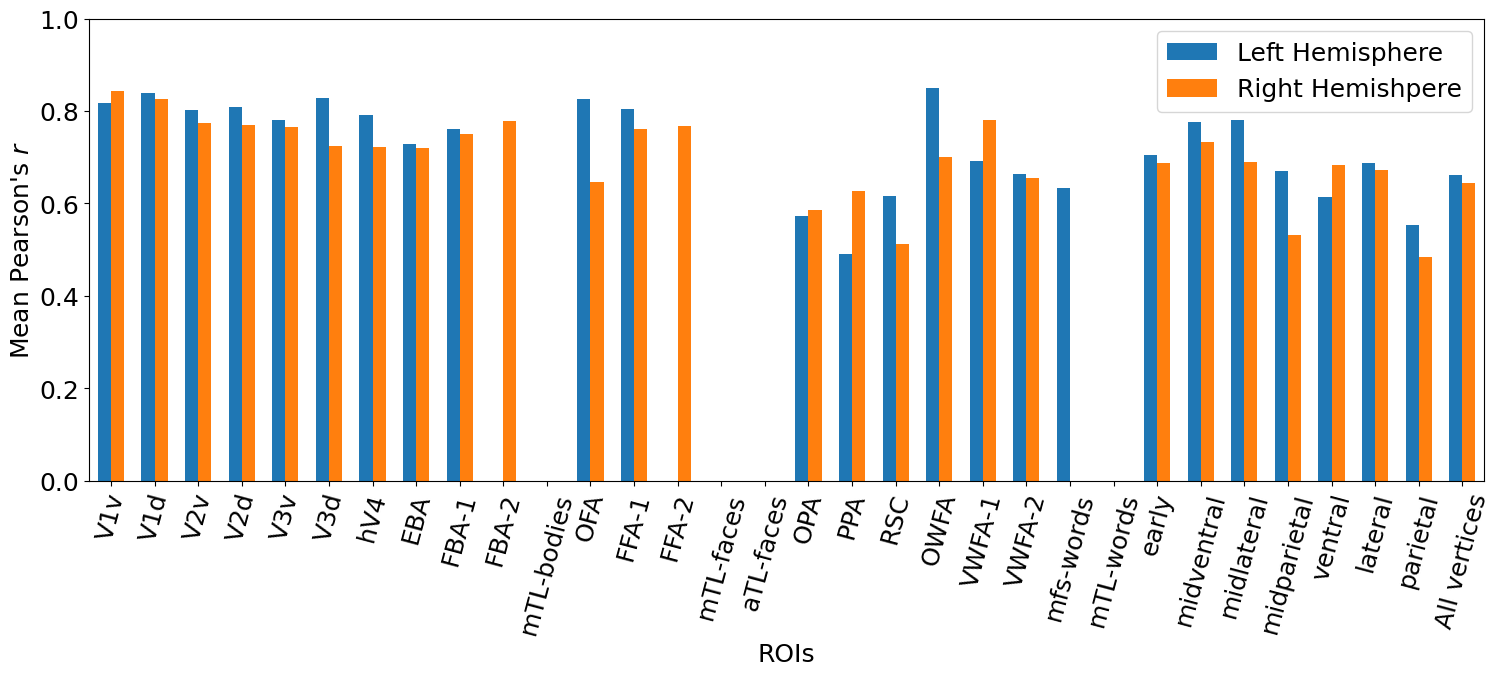

subj: 1   lh_corr: 0.662440562021631   rh_corr: 0.6449966859042344
subj: 2
(6, 159, 20544)


100%|██████████| 20544/20544 [00:12<00:00, 1669.29it/s]


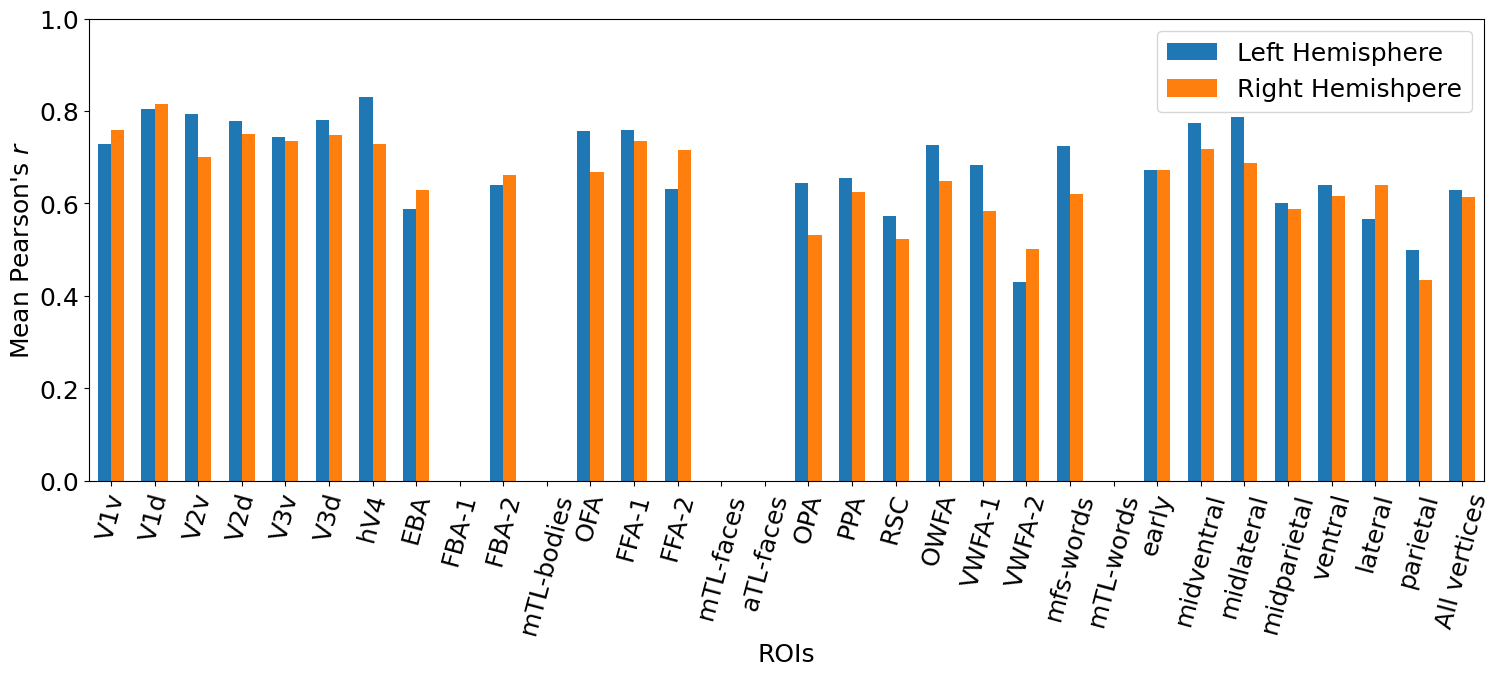

subj: 2   lh_corr: 0.6285629292137833   rh_corr: 0.6131732245102208
subj: 3
(6, 293, 20544)


100%|██████████| 20544/20544 [00:12<00:00, 1701.18it/s]


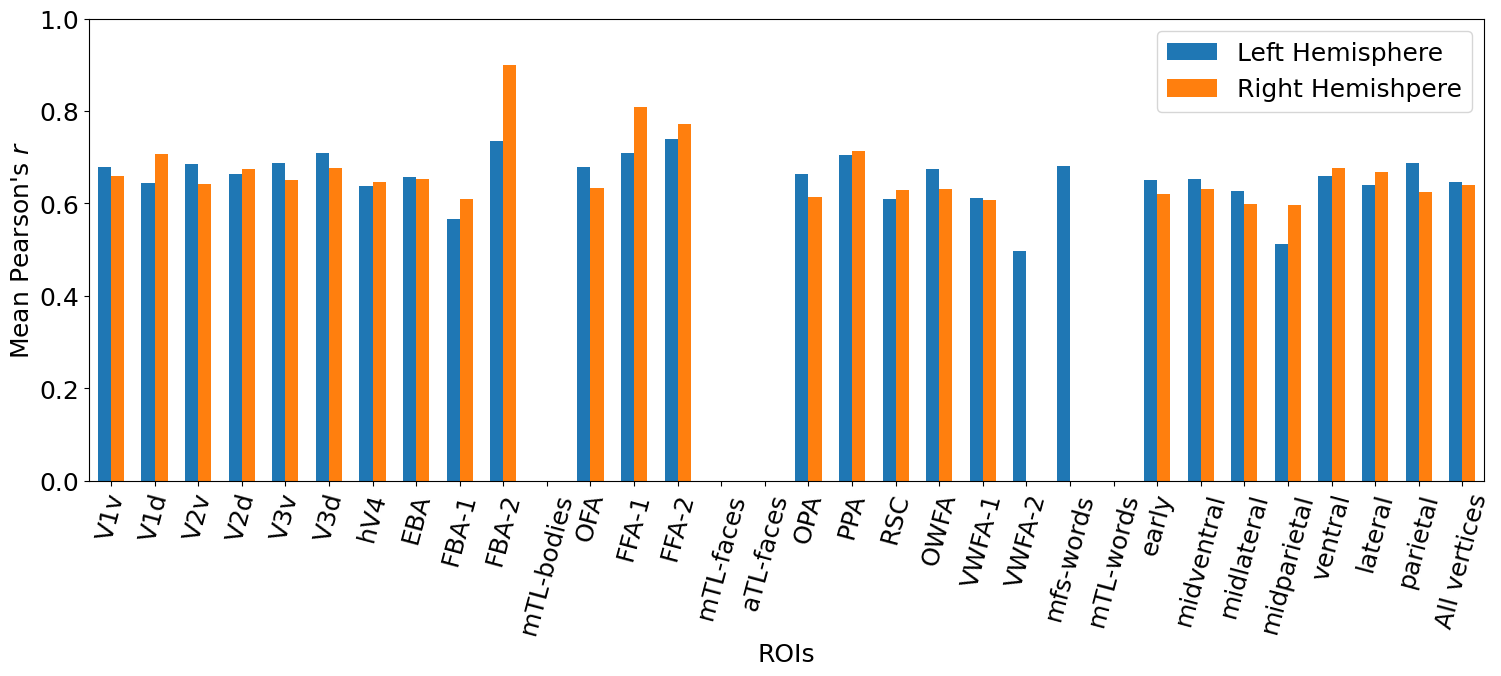

subj: 3   lh_corr: 0.6471768216151517   rh_corr: 0.6390630263052451
subj: 4
(6, 395, 20544)


100%|██████████| 20544/20544 [00:12<00:00, 1680.88it/s]


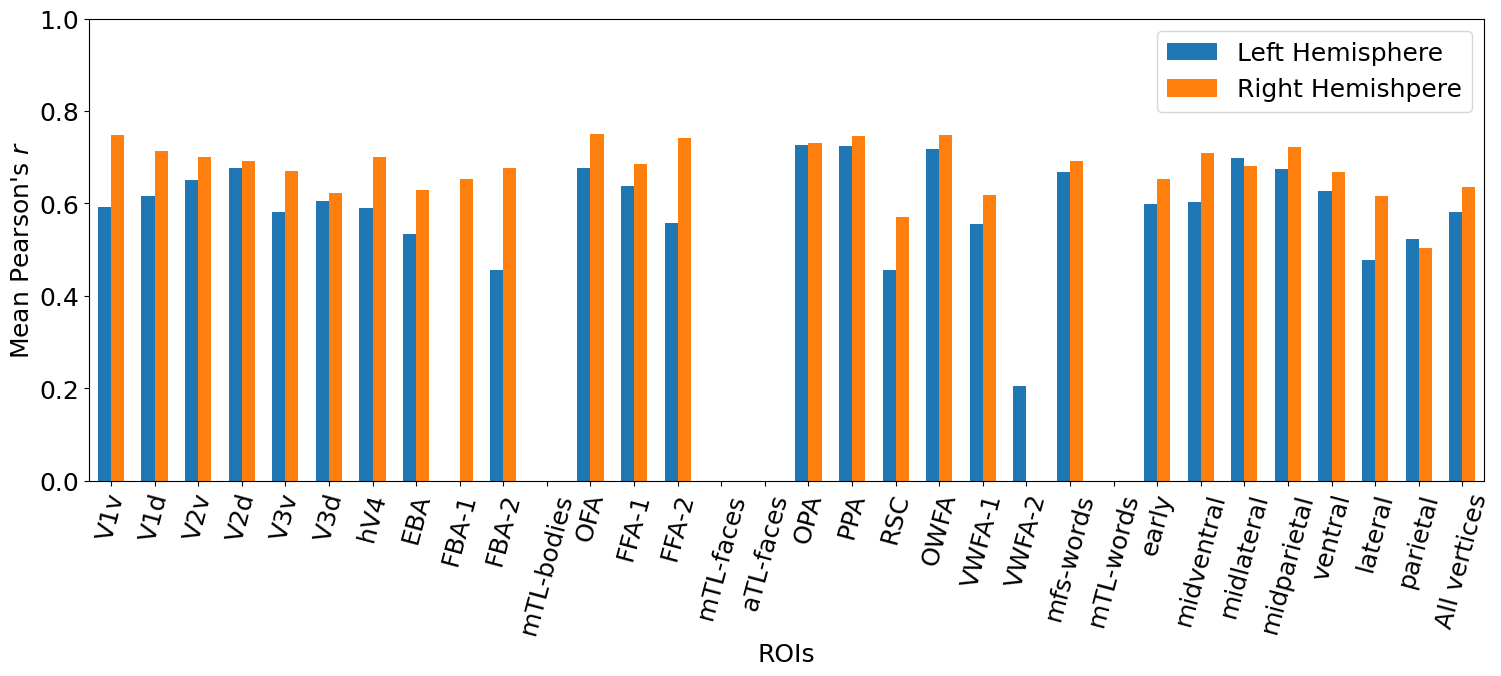

subj: 4   lh_corr: 0.581025674083685   rh_corr: 0.6360892390375941
subj: 5
(6, 159, 20544)


100%|██████████| 20544/20544 [00:12<00:00, 1696.70it/s]


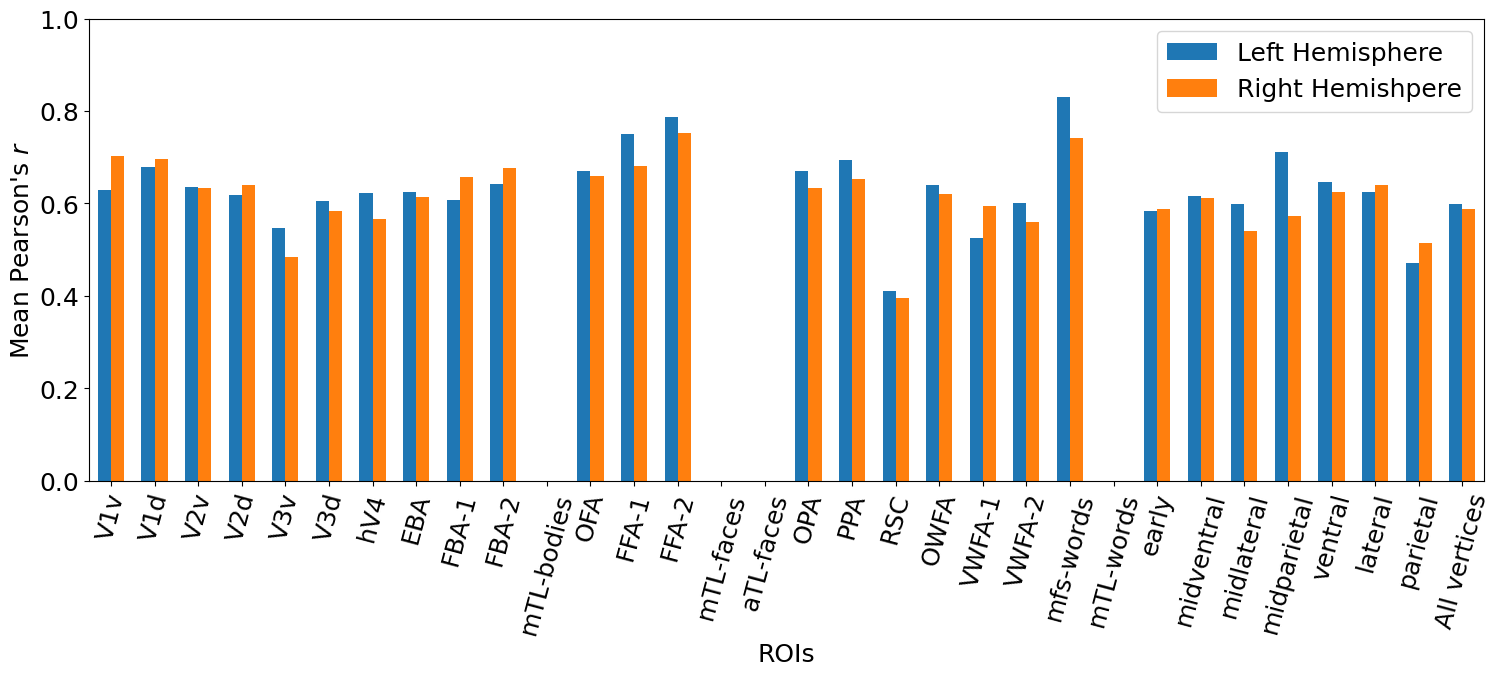

subj: 5   lh_corr: 0.5976792725858507   rh_corr: 0.5878788760220205
subj: 6
(6, 293, 20220)


100%|██████████| 20220/20220 [00:12<00:00, 1682.76it/s]


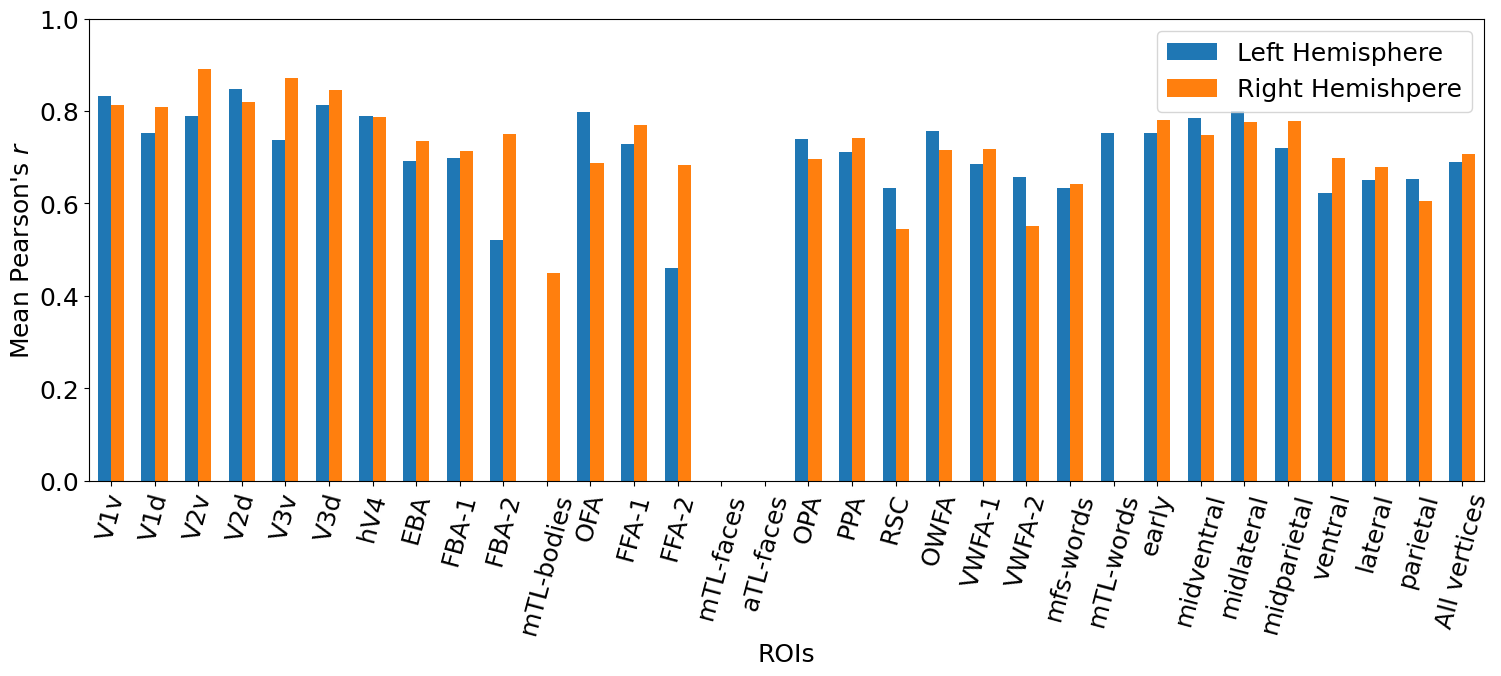

subj: 6   lh_corr: 0.6891341705438088   rh_corr: 0.7074785863293185
subj: 7
(6, 159, 20544)


100%|██████████| 20544/20544 [00:12<00:00, 1697.49it/s]


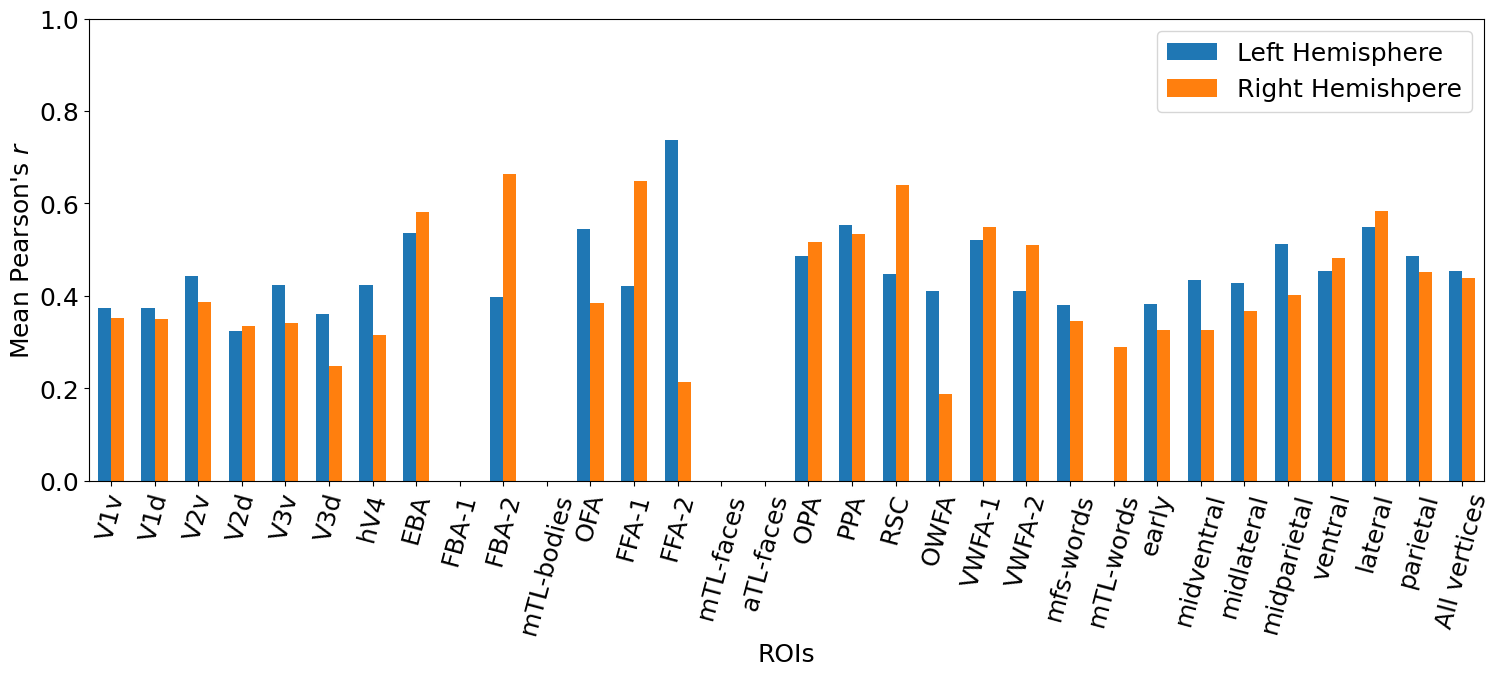

subj: 7   lh_corr: 0.4527392986546551   rh_corr: 0.43904962779787116
subj: 8
(6, 395, 20530)


100%|██████████| 20530/20530 [00:12<00:00, 1648.96it/s]


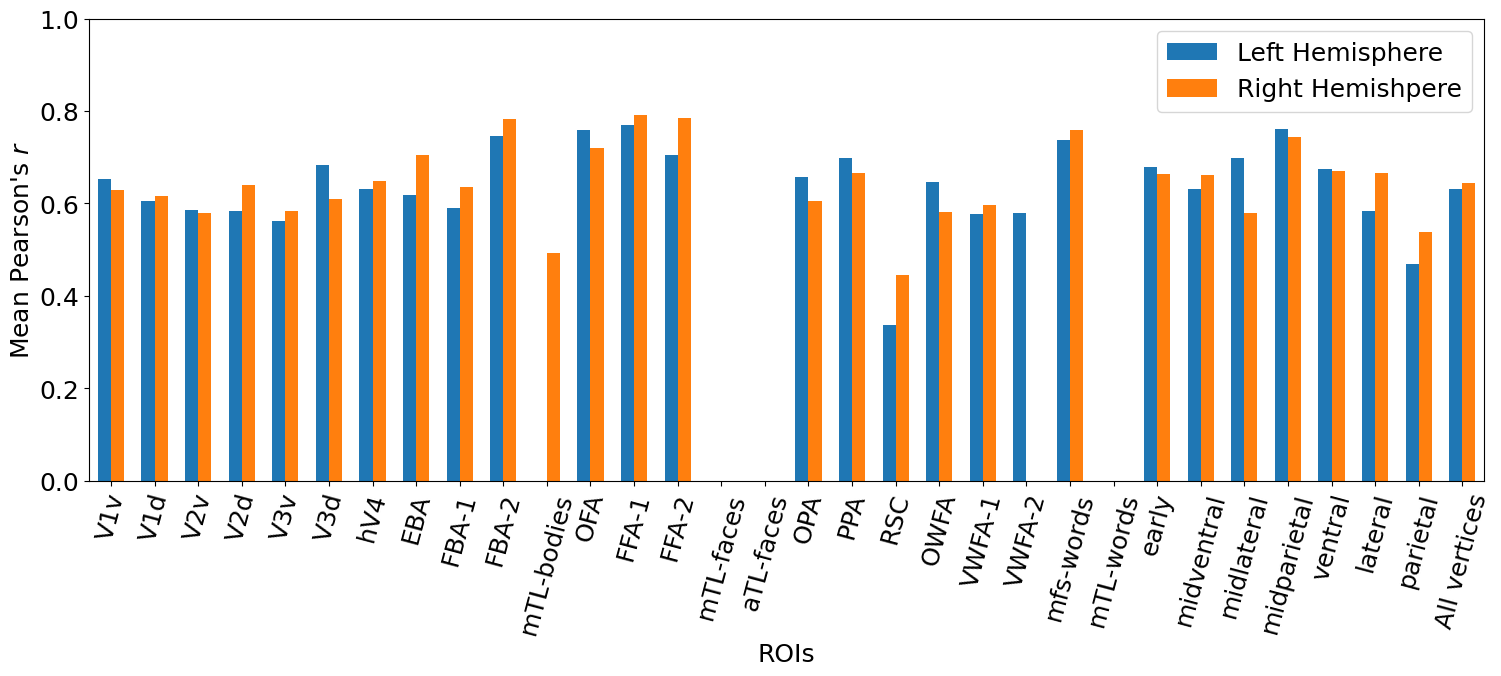

subj: 8   lh_corr: 0.6309637175489514   rh_corr: 0.644423392584316
lh_corr_mean: 0.6112153057834396   rh_corr_mean: 0.6140190823113525


([0.662440562021631,
  0.6285629292137833,
  0.6471768216151517,
  0.581025674083685,
  0.5976792725858507,
  0.6891341705438088,
  0.4527392986546551,
  0.6309637175489514],
 [0.6449966859042344,
  0.6131732245102208,
  0.6390630263052451,
  0.6360892390375941,
  0.5878788760220205,
  0.7074785863293185,
  0.43904962779787116,
  0.644423392584316],
 array([0.66020538, 0.2092492 , 0.74090238, ..., 0.44303236, 0.34490664,
        0.80815675]),
 array([0.49423479, 0.43974008, 0.1163876 , ..., 0.34643542, 0.46591727,
        0.14298563]))

In [62]:
from scipy.special import softmax

def evaluate_combined_model():

    lh_corr = []
    rh_corr = []

    for subj in args.subjects:
        print(f'subj: {subj}')
        # class argObj:
        #     def __init__(self, data_dir, subj):

        args.subj = format(subj, '02')
        args.data_dir = os.path.join(data_dir, 'subj'+args.subj)

        roi_name_maps, lh_challenge_rois, rh_challenge_rois = roi_maps(args.data_dir)
        
        lh_correlation = []
        rh_correlation = []

        lh_pred_test = []
        rh_pred_test = []

        lh_pred_corr = []
        rh_pred_corr = [] 
        
        
        for lay in [1, 3, 5, 7, 9, 11]:
            lay_res_dir = f'./results/nsd_test/{args.arch}/subj_{args.subj}/{args.readout_res}/enc_{lay}/'
            
            lh_correlation_lay = []
            rh_correlation_lay = []

            lh_fmri_pred_lay = []
            rh_fmri_pred_lay = []

            for run in args.runs:
                run_res_dir = lay_res_dir + f'/run_{run}/'

                lh_correlation = np.load(run_res_dir + 'lh_val_corr.npy')
                rh_correlation = np.load(run_res_dir + 'rh_val_corr.npy')

                lh_correlation_lay.append(lh_correlation)
                rh_correlation_lay.append(rh_correlation)

                lh_fmri_pred = np.load(run_res_dir + 'lh_pred_test.npy')
                rh_fmri_pred = np.load(run_res_dir + 'rh_pred_test.npy')

                lh_fmri_pred_lay.append(lh_fmri_pred)
                rh_fmri_pred_lay.append(rh_fmri_pred)

            lh_correlation_lay = np.array(lh_correlation_lay).mean(0)
            rh_correlation_lay = np.array(rh_correlation_lay).mean(0)

            lh_fmri_pred_lay = np.array(lh_fmri_pred_lay).mean(0)
            rh_fmri_pred_lay = np.array(rh_fmri_pred_lay).mean(0)

            lh_pred_corr.append(lh_correlation_lay)
            rh_pred_corr.append(rh_correlation_lay)

            lh_pred_test.append(lh_fmri_pred_lay)
            rh_pred_test.append(rh_fmri_pred_lay)

        lh_pred_corr = np.array(lh_pred_corr)
        rh_pred_corr = np.array(rh_pred_corr)

        lh_pred_test = np.array(lh_pred_test)
        rh_pred_test = np.array(rh_pred_test)

        lh_corr_sm = softmax(50*lh_pred_corr, axis=0)
        lh_corr_sm = np.tile(np.expand_dims(lh_corr_sm,1), (1,lh_pred_test.shape[1],1))
        lh_pred = np.multiply(lh_corr_sm, lh_pred_test).sum(0)
        
        rh_corr_sm = softmax(50*rh_pred_corr, axis=0)
        rh_corr_sm = np.tile(np.expand_dims(rh_corr_sm,1), (1,rh_pred_test.shape[1],1))
        print(rh_corr_sm.shape)
        rh_pred = np.multiply(rh_corr_sm, rh_pred_test).sum(0)


        fmri_dir = os.path.join(args.data_dir, 'test_split', 'test_fmri')
        lh_fmri_test = np.load(os.path.join(fmri_dir, 'lh_test_fmri.npy'))
        rh_fmri_test = np.load(os.path.join(fmri_dir, 'rh_test_fmri.npy'))

        fmri_noise_dir = os.path.join(args.data_dir, 'test_split', 'noise_ceiling')
        lh_nc = np.load(os.path.join(fmri_noise_dir, 'lh_noise_ceiling.npy'))
        rh_nc = np.load(os.path.join(fmri_noise_dir, 'rh_noise_ceiling.npy'))

        lh_correlation, rh_correlation = corr_measure(args.data_dir, lh_fmri_test, rh_fmri_test, lh_pred, rh_pred)

        lh_correlation[lh_correlation<0] = 0
        rh_correlation[rh_correlation<0] = 0

        #if args.split == 'test' and args.measure == 'exp_var':
        lh_r2 = lh_correlation ** 2
        rh_r2 = rh_correlation ** 2

        lh_nc[lh_nc==0] = 1e-14
        rh_nc[rh_nc==0] = 1e-14

        # Compute the noise-ceiling-normalized encoding accuracy
        expl_var_lh = np.divide(lh_r2, lh_nc)
        expl_var_rh = np.divide(rh_r2, rh_nc)

        # Set the noise-ceiling-normalized encoding accuracy to 1 for those vertices
        # in which the r2 scores are higher than the noise ceiling, to prevent
        # encoding accuracy values higher than 100%
        expl_var_lh[expl_var_lh>1] = 1
        expl_var_rh[expl_var_rh>1] = 1

        lh_correlation = expl_var_lh
        rh_correlation = expl_var_rh
        
        # Select the correlation results vertices of each ROI
        roi_names = []
        lh_roi_correlation = []
        rh_roi_correlation = []
        for r1 in range(len(lh_challenge_rois)):
            for r2 in roi_name_maps[r1].items():
                if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
                    roi_names.append(r2[1])
                    lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
                    rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
                    lh_roi_correlation.append(lh_correlation[lh_roi_idx])
                    rh_roi_correlation.append(rh_correlation[rh_roi_idx])
        roi_names.append('All vertices')
        lh_roi_correlation.append(lh_correlation)
        rh_roi_correlation.append(rh_correlation)


        # Create the plot
        lh_mean_roi_correlation = [np.mean(np.nan_to_num(np.array(lh_roi_correlation[r]), copy=True, nan=0.0, posinf=None, neginf=None))
            for r in range(len(lh_roi_correlation))]
        rh_mean_roi_correlation = [np.mean(np.nan_to_num(np.array(rh_roi_correlation[r]), copy=True, nan=0.0, posinf=None, neginf=None))
            for r in range(len(rh_roi_correlation))]

        plt.rcParams.update({'font.size': 18})

        if args.plot_figs:
            fig = plt.figure(figsize=(18,6))
            x = np.arange(len(roi_names))
            width = 0.30
            plt.bar(x - width/2, lh_mean_roi_correlation, width, label='Left Hemisphere')
            plt.bar(x + width/2, rh_mean_roi_correlation, width,
                label='Right Hemishpere')
            plt.xlim(left=min(x)-.5, right=max(x)+.5)
            plt.ylim(bottom=0, top=1)
            plt.xlabel('ROIs')
            plt.xticks(ticks=x, labels=roi_names, rotation=75)
            plt.ylabel('Mean Pearson\'s $r$')
            plt.legend(frameon=True, loc=1);
            plt.show()
            
            #fig.savefig('figures/detr_dino_8_visuals_16.pdf', format='pdf', bbox_inches="tight")
            #fig.savefig('figures/detr_dino_1_streams_inc_16.jpg', dpi=300, bbox_inches="tight")

        lh_corr.append(lh_mean_roi_correlation[-1])
        rh_corr.append(rh_mean_roi_correlation[-1])

        if args.verbose:
            print(f'subj: {subj}   lh_corr: {lh_mean_roi_correlation[-1]}   rh_corr: {rh_mean_roi_correlation[-1]}')

    if args.verbose:
        print(f'lh_corr_mean: {np.array(lh_corr).mean()}   rh_corr_mean: {np.array(rh_corr).mean()}')

    return lh_corr, rh_corr, lh_correlation, rh_correlation


evaluate_combined_model()

subj: 5
(10, 159, 20544)


100%|██████████| 20544/20544 [00:12<00:00, 1603.39it/s]


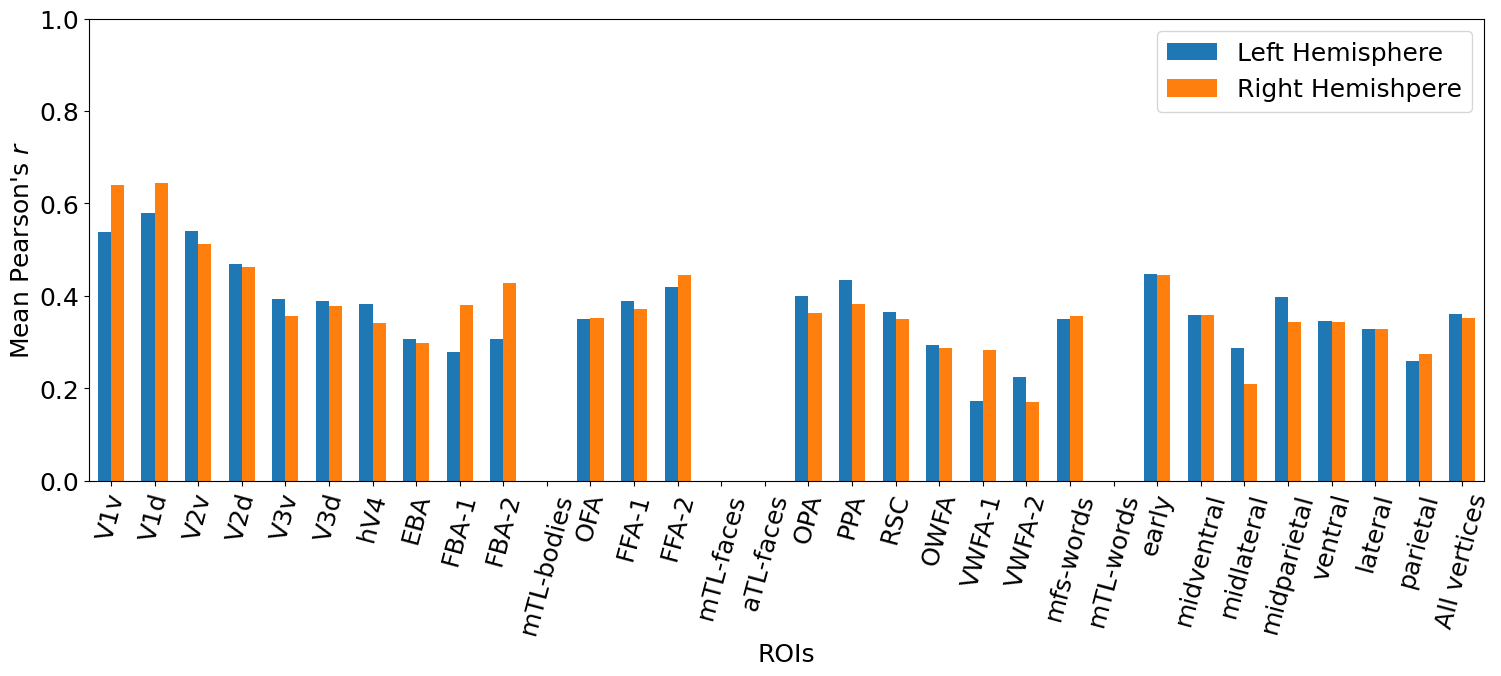

subj: 5   lh_corr: 0.3599672033993908   rh_corr: 0.35277935972779795
lh_corr_mean: 0.3599672033993908   rh_corr_mean: 0.35277935972779795


([0.3599672033993908],
 [0.35277935972779795],
 array([0.27928655, 0.43073269, 0.63942955, ..., 0.26943889, 0.26799303,
        0.54191051]),
 array([5.84670387e-01, 3.85726805e-01, 3.80460058e-01, ...,
        1.40983567e-04, 0.00000000e+00, 1.49573799e-03]))

In [28]:
from scipy.special import softmax

def evaluate_combined_model():

    lh_corr = []
    rh_corr = []

    for subj in args.subjects:
        print(f'subj: {subj}')
        # class argObj:
        #     def __init__(self, data_dir, subj):

        args.subj = format(subj, '02')
        args.data_dir = os.path.join(data_dir, 'subj'+args.subj)

        roi_name_maps, lh_challenge_rois, rh_challenge_rois = roi_maps(args.data_dir)
        
        lh_correlation = []
        rh_correlation = []

        lh_pred_test = []
        rh_pred_test = []

        lh_pred_corr = []
        rh_pred_corr = [] 
        
        
        for lay in [11]: # [1, 3, 5, 7, 9, 11]:
            lay_res_dir = f'./results/nsd_test/{args.arch}/subj_{args.subj}/{args.readout_res}/enc_{lay}/'
            
            for run in args.runs:
                run_res_dir = lay_res_dir + f'/run_{run}/'

                lh_correlation = np.load(run_res_dir + 'lh_val_corr.npy')
                rh_correlation = np.load(run_res_dir + 'rh_val_corr.npy')

                lh_pred_corr.append(lh_correlation)
                rh_pred_corr.append(rh_correlation)

                lh_fmri_pred = np.load(run_res_dir + 'lh_pred_test.npy')
                rh_fmri_pred = np.load(run_res_dir + 'rh_pred_test.npy')

                lh_pred_test.append(lh_fmri_pred)
                rh_pred_test.append(rh_fmri_pred)

        lh_pred_test = np.array(lh_pred_test)
        rh_pred_test = np.array(rh_pred_test)

        lh_pred_corr = np.array(lh_pred_corr)
        rh_pred_corr = np.array(rh_pred_corr)

        lh_corr_sm = softmax(40*lh_pred_corr, axis=0)
        lh_corr_sm = np.tile(np.expand_dims(lh_corr_sm,1), (1,lh_pred_test.shape[1],1))
        lh_pred = np.multiply(lh_corr_sm, lh_pred_test).sum(0)
        
        rh_corr_sm = softmax(40*rh_pred_corr, axis=0)
        rh_corr_sm = np.tile(np.expand_dims(rh_corr_sm,1), (1,rh_pred_test.shape[1],1))
        print(rh_corr_sm.shape)
        rh_pred = np.multiply(rh_corr_sm, rh_pred_test).sum(0)


        fmri_dir = os.path.join(args.data_dir, 'test_split', 'test_fmri')
        lh_fmri_test = np.load(os.path.join(fmri_dir, 'lh_test_fmri.npy'))
        rh_fmri_test = np.load(os.path.join(fmri_dir, 'rh_test_fmri.npy'))

        fmri_noise_dir = os.path.join(args.data_dir, 'test_split', 'noise_ceiling')
        lh_nc = np.load(os.path.join(fmri_noise_dir, 'lh_noise_ceiling.npy'))
        rh_nc = np.load(os.path.join(fmri_noise_dir, 'rh_noise_ceiling.npy'))

        lh_correlation, rh_correlation = corr_measure(args.data_dir, lh_fmri_test, rh_fmri_test, lh_pred, rh_pred)

        lh_correlation[lh_correlation<0] = 0
        rh_correlation[rh_correlation<0] = 0

        #if args.split == 'test' and args.measure == 'exp_var':
        lh_r2 = lh_correlation ** 2
        rh_r2 = rh_correlation ** 2

        lh_nc[lh_nc==0] = 1e-14
        rh_nc[rh_nc==0] = 1e-14

        # Compute the noise-ceiling-normalized encoding accuracy
        expl_var_lh = np.divide(lh_r2, lh_nc)
        expl_var_rh = np.divide(rh_r2, rh_nc)

        # Set the noise-ceiling-normalized encoding accuracy to 1 for those vertices
        # in which the r2 scores are higher than the noise ceiling, to prevent
        # encoding accuracy values higher than 100%
        expl_var_lh[expl_var_lh>1] = 1
        expl_var_rh[expl_var_rh>1] = 1

        lh_correlation = expl_var_lh
        rh_correlation = expl_var_rh
        
        # Select the correlation results vertices of each ROI
        roi_names = []
        lh_roi_correlation = []
        rh_roi_correlation = []
        for r1 in range(len(lh_challenge_rois)):
            for r2 in roi_name_maps[r1].items():
                if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
                    roi_names.append(r2[1])
                    lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
                    rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
                    lh_roi_correlation.append(lh_correlation[lh_roi_idx])
                    rh_roi_correlation.append(rh_correlation[rh_roi_idx])
        roi_names.append('All vertices')
        lh_roi_correlation.append(lh_correlation)
        rh_roi_correlation.append(rh_correlation)


        # Create the plot
        lh_mean_roi_correlation = [np.mean(np.nan_to_num(np.array(lh_roi_correlation[r]), copy=True, nan=0.0, posinf=None, neginf=None))
            for r in range(len(lh_roi_correlation))]
        rh_mean_roi_correlation = [np.mean(np.nan_to_num(np.array(rh_roi_correlation[r]), copy=True, nan=0.0, posinf=None, neginf=None))
            for r in range(len(rh_roi_correlation))]

        plt.rcParams.update({'font.size': 18})

        if args.plot_figs:
            fig = plt.figure(figsize=(18,6))
            x = np.arange(len(roi_names))
            width = 0.30
            plt.bar(x - width/2, lh_mean_roi_correlation, width, label='Left Hemisphere')
            plt.bar(x + width/2, rh_mean_roi_correlation, width,
                label='Right Hemishpere')
            plt.xlim(left=min(x)-.5, right=max(x)+.5)
            plt.ylim(bottom=0, top=1)
            plt.xlabel('ROIs')
            plt.xticks(ticks=x, labels=roi_names, rotation=75)
            plt.ylabel('Mean Pearson\'s $r$')
            plt.legend(frameon=True, loc=1);
            plt.show()
            
            #fig.savefig('figures/detr_dino_8_visuals_16.pdf', format='pdf', bbox_inches="tight")
            #fig.savefig('figures/detr_dino_1_streams_inc_16.jpg', dpi=300, bbox_inches="tight")

        lh_corr.append(lh_mean_roi_correlation[-1])
        rh_corr.append(rh_mean_roi_correlation[-1])

        if args.verbose:
            print(f'subj: {subj}   lh_corr: {lh_mean_roi_correlation[-1]}   rh_corr: {rh_mean_roi_correlation[-1]}')

    if args.verbose:
        print(f'lh_corr_mean: {np.array(lh_corr).mean()}   rh_corr_mean: {np.array(rh_corr).mean()}')

    return lh_corr, rh_corr, lh_correlation, rh_correlation


evaluate_combined_model()

Save figures related to subj 1

subj: 1
run: 1
./results/nsd_test/dinov2_q_transformer/subj_01/streams_inc/enc_1/run_1/
run: 2
./results/nsd_test/dinov2_q_transformer/subj_01/streams_inc/enc_1/run_2/
run: 3
./results/nsd_test/dinov2_q_transformer/subj_01/streams_inc/enc_1/run_3/
run: 4
./results/nsd_test/dinov2_q_transformer/subj_01/streams_inc/enc_1/run_4/
run: 5
./results/nsd_test/dinov2_q_transformer/subj_01/streams_inc/enc_1/run_5/
run: 6
./results/nsd_test/dinov2_q_transformer/subj_01/streams_inc/enc_1/run_6/
run: 7
./results/nsd_test/dinov2_q_transformer/subj_01/streams_inc/enc_1/run_7/
run: 8
./results/nsd_test/dinov2_q_transformer/subj_01/streams_inc/enc_1/run_8/
run: 9
./results/nsd_test/dinov2_q_transformer/subj_01/streams_inc/enc_1/run_9/
run: 10
./results/nsd_test/dinov2_q_transformer/subj_01/streams_inc/enc_1/run_10/


100%|██████████| 20544/20544 [00:12<00:00, 1703.60it/s]
/home/ha2366/.conda/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ha2366/.conda/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


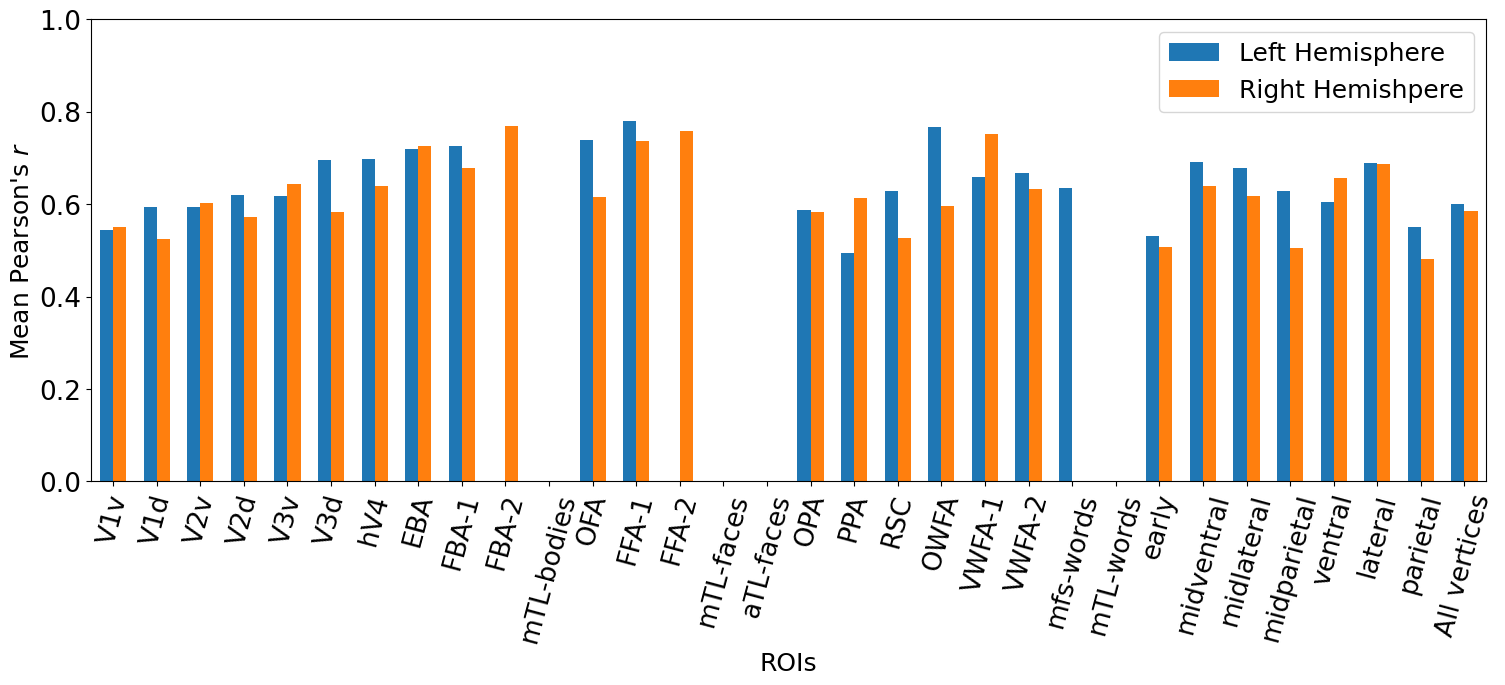

subj: 1   lh_corr: 0.601358615267781   rh_corr: 0.5849808938067788
lh_corr_mean: 0.601358615267781   rh_corr_mean: 0.5849808938067788


In [ ]:
class model_argObj:
    def __init__(self, arch, feature_name, readout_res, enc_output_layer, learn_reg):

        self.arch = arch
        self.feature_name = feature_name
        self.readout_res = readout_res
        self.enc_output_layer = enc_output_layer
        self.learn_reg = learn_reg

        self.subjects = np.arange(1,2)
        self.runs = np.arange(1,2)
        
        self.split = 'test' # test
        self.measure = 'exp_var'  # 'corr'
        self.verbose = 1
        self.plot_figs = 1


qargs = []
qargs.append(['dinov2_q_transformer', 'dinov2_q_last', 'streams_inc', 1, 0])

args = model_argObj(*qargs[0])

lh_corr, rh_corr, lh_correlation, rh_correlation = evaluate_model(args)

/tmp/ipykernel_184872/1989635242.py:47: RuntimeWarning: Mean of empty slice
  lh_fsaverage = np.nanmean(lh_fsaverage, 0)
/tmp/ipykernel_184872/1989635242.py:48: RuntimeWarning: Mean of empty slice
  rh_fsaverage = np.nanmean(rh_fsaverage, 0)


Setting _INKSCAPE_GC=disable as a workaround for broken libgc
Unable to init server: Could not connect: Connection refused
(ld-linux-x86-64.so.2:5654): glibmm-WARNING **: 15:09:06.725: Failed to wrap object of type 'GtkRecentManager'. Hint: this error is commonly caused by failing to call a library init() function.
(ld-linux-x86-64.so.2:5654): Pango-CRITICAL **: 15:09:06.726: pango_font_get_hb_font: assertion 'PANGO_IS_FONT (font)' failed
(ld-linux-x86-64.so.2:5654): GLib-GObject-CRITICAL **: 15:09:06.726: g_object_unref: assertion 'G_IS_OBJECT (object)' failed
(ld-linux-x86-64.so.2:5654): Pango-CRITICAL **: 15:09:06.744: pango_font_get_hb_font: assertion 'PANGO_IS_FONT (font)' failed
(ld-linux-x86-64.so.2:5654): GLib-GObject-CRITICAL **: 15:09:06.744: g_object_unref: assertion 'G_IS_OBJECT (object)' failed
** (ld-linux-x86-64.so.2:5654): WARNING **: 15:09:06.751: SPObject::updateDisplay(SPCtx *ctx, unsigned int flags) : throw in ((SPObjectClass *) G_OBJECT_GET_CLASS(this))->update(thi

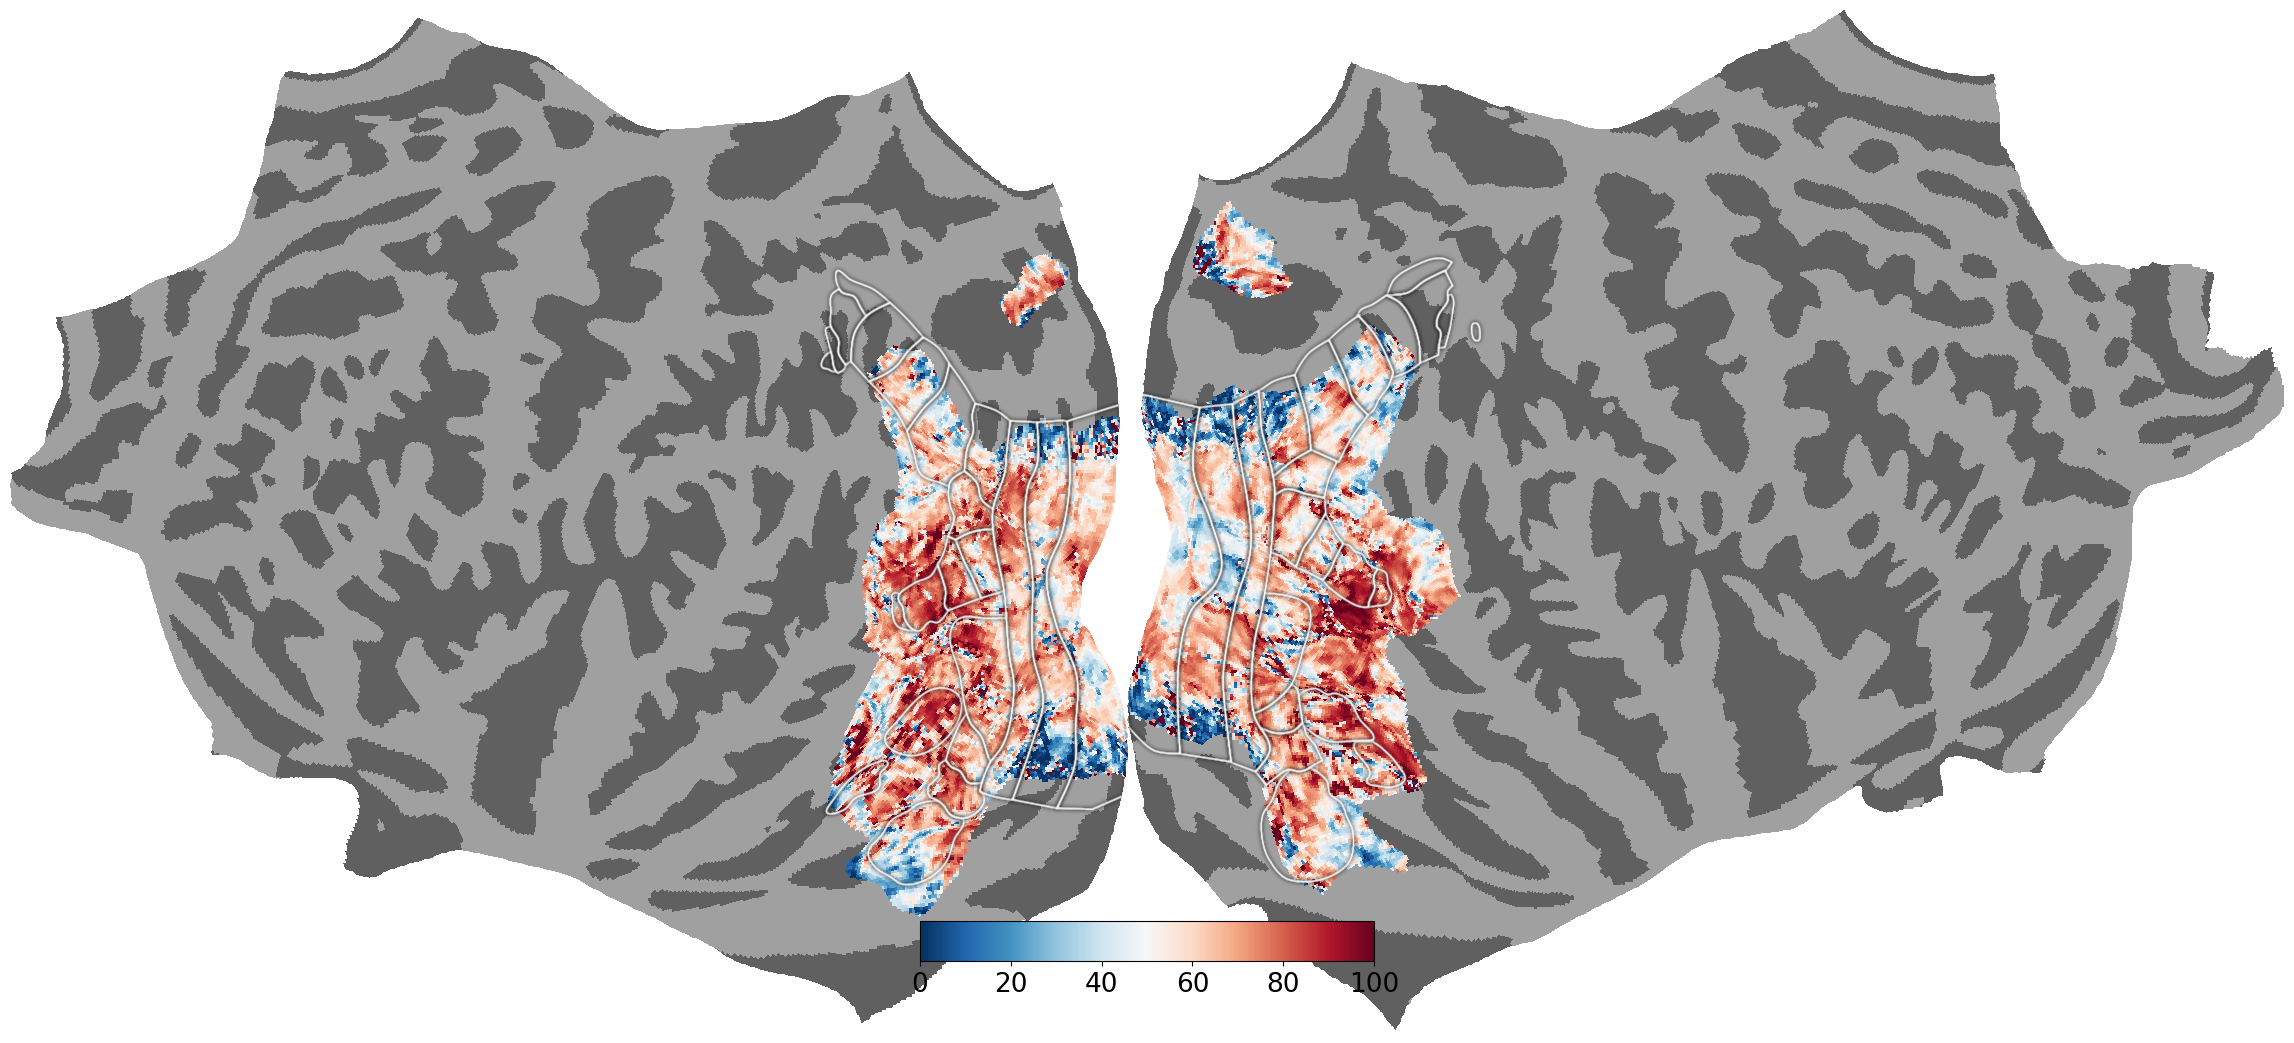

In [51]:
"""Plot data on a flattened brain surface using pycortex.

"""

import os
from copy import copy
import numpy as np
from matplotlib import pyplot as plt
import cortex
import cortex.polyutils

# =============================================================================
# Map the data to fsaverage space
# =============================================================================
# pycortex requires data in fsaverage space, so here you map the vertices from
# Challenge space into fsaverage space. The voxels not used in the Challenge
# are given NaN values, so that pycortex ignores them for the plotting.
# "ls_scores" and "rh_scores" are lists with 8 elements, one for each subject.
# These elements consist of vectors of length N, where N is the vertex amount
# for each subject and hemisphere, and each vector component consists of the
# prediction accuracy for that vertex.

#challenge_data_dir = '../algonauts_2023_challenge_data'
challenge_data_dir = '/engram/nklab/algonauts/algonauts_2023_challenge_data/'
lh_fsaverage = []
rh_fsaverage = []
subjects = [1]
for s, sub in enumerate(subjects):
    lh_mask_dir = os.path.join(challenge_data_dir, 'subj'+format(sub, '02'),
        'roi_masks', 'lh.all-vertices_fsaverage_space.npy')
    rh_mask_dir = os.path.join(challenge_data_dir, 'subj'+format(sub, '02'),
        'roi_masks', 'rh.all-vertices_fsaverage_space.npy')
    lh_fsaverage_all_vertices = np.load(lh_mask_dir)
    rh_fsaverage_all_vertices = np.load(rh_mask_dir)
    lh_fsavg = np.empty((len(lh_fsaverage_all_vertices)))
    lh_fsavg[:] = np.nan
    lh_fsavg[np.where(lh_fsaverage_all_vertices)[0]] = lh_correlation #lh_scores[s]
    lh_fsaverage.append(copy(lh_fsavg))
    rh_fsavg = np.empty((len(rh_fsaverage_all_vertices)))
    rh_fsavg[:] = np.nan
    rh_fsavg[np.where(rh_fsaverage_all_vertices)[0]] = rh_correlation #rh_scores[s]
    rh_fsaverage.append(copy(rh_fsavg))
    
    break

# Average the scores across subjects
lh_fsaverage = np.nanmean(lh_fsaverage, 0)
rh_fsaverage = np.nanmean(rh_fsaverage, 0)


# =============================================================================
# Plot parameters for colorbar
# =============================================================================
plt.rc('xtick', labelsize=19)
plt.rc('ytick', labelsize=19)


# =============================================================================
# Plot the results on brain surfaces
# =============================================================================
subject = 'fsaverage'
data = np.append(lh_fsaverage, rh_fsaverage) * 100
vertex_data = cortex.Vertex(data, subject, cmap='RdBu_r', vmin=0, vmax=100)
cortex.quickshow(vertex_data, with_curvature=True)
plt.savefig('my_plot.png', dpi=300) 
plt.show()



## Test on the test set

In [13]:
lh_noise.shape

(19004,)

In [11]:
np.clip(lh_correlation / lh_noise, a_max=1, a_min=0)

/tmp/ipykernel_189419/1153093882.py:1: RuntimeWarning: divide by zero encountered in divide
  np.clip(lh_correlation / lh_noise, a_max=1, a_min=0)


array([1.        , 0.83799336, 0.97925566, ..., 0.78614328, 0.87802989,
       1.        ])

In [21]:
split = 'test' # test
measure = 'exp_var'  # 'corr'

arch = 'dinov2_q_transformer' #'resnet50_transformer' # dinov2_q_transformer
feature_name = 'dinov2_q_last' # 'resnet50'  # dinov2_q_last

# arch = 'resnet50_transformer' #'resnet50_transformer' # dinov2_q_transformer
# feature_name = 'resnet50' # 'resnet50'  # dinov2_q_last

readout_res = 'voxels'  # [streams_inc', 'visuals', 'bodies', 'places', 'faces', 'words']
enc_output_layer = 1

learn_reg = 0


lh_corr = []
rh_corr = []

for subj in [1]: #range(1,9):
    print(f'subj: {subj}')
    class argObj:
        def __init__(self, data_dir, subj):

            self.subj = format(subj, '02')
            self.data_dir = os.path.join(data_dir, 'subj'+self.subj)

    args = argObj(data_dir, subj)

    roi_name_maps, lh_challenge_rois, rh_challenge_rois = roi_maps(args.data_dir)

    fmri_dir = os.path.join(args.data_dir, 'test_split', 'test_fmri')
    lh_fmri_test = np.load(os.path.join(fmri_dir, 'lh_test_fmri.npy'))
    rh_fmri_test = np.load(os.path.join(fmri_dir, 'rh_test_fmri.npy'))

    fmri_noise_dir = os.path.join(args.data_dir, 'test_split', 'noise_ceiling')
    lh_nc = np.load(os.path.join(fmri_noise_dir, 'lh_noise_ceiling.npy'))
    rh_nc = np.load(os.path.join(fmri_noise_dir, 'rh_noise_ceiling.npy'))

    lh_correlation_all_layers = []
    rh_correlation_all_layers = []

    for enc_output_layer in range(1, 13):
        
        print(f'enc_output_layer: {enc_output_layer}')
        lh_pred = []
        rh_pred = []
        for run in range(1, 4):
            print(f'run: {run}')
            subj_res_dir = f'./results/nsd_test/{arch}/subj_{args.subj}/{readout_res}/enc_{enc_output_layer}/run_{run}/'

            lh_pred.append(np.load(subj_res_dir + 'lh_pred_test.npy'))
            rh_pred.append(np.load(subj_res_dir + 'rh_pred_test.npy'))
        
        lh_fmri_pred = np.mean(lh_pred, axis=0)
        rh_fmri_pred = np.mean(rh_pred, axis=0)


        print(lh_fmri_test.shape, rh_fmri_test.shape, lh_fmri_pred.shape, rh_fmri_pred.shape)
        lh_correlation, rh_correlation = corr_measure(args.data_dir, lh_fmri_test, rh_fmri_test, lh_fmri_pred, rh_fmri_pred)

        lh_correlation[lh_correlation<0] = 0
        rh_correlation[rh_correlation<0] = 0

        if split == 'test' and measure == 'exp_var':
            lh_r2 = lh_correlation ** 2
            rh_r2 = rh_correlation ** 2

            lh_nc[lh_nc==0] = 1e-14
            rh_nc[rh_nc==0] = 1e-14

            # Compute the noise-ceiling-normalized encoding accuracy
            expl_var_lh = np.divide(lh_r2, lh_nc)
            expl_var_rh = np.divide(rh_r2, rh_nc)

            # Set the noise-ceiling-normalized encoding accuracy to 1 for those vertices
            # in which the r2 scores are higher than the noise ceiling, to prevent
            # encoding accuracy values higher than 100%
            expl_var_lh[expl_var_lh>1] = 1
            expl_var_rh[expl_var_rh>1] = 1

            lh_correlation = expl_var_lh
            rh_correlation = expl_var_rh

        lh_correlation_all_layers.append(lh_correlation)
        rh_correlation_all_layers.append(rh_correlation)
    

subj: 1
enc_output_layer: 1
run: 1
run: 2
run: 3
(159, 19004) (159, 20544) (159, 19004) (159, 20544)


100%|██████████| 20544/20544 [00:11<00:00, 1713.85it/s]


enc_output_layer: 2
run: 1
run: 2
run: 3
(159, 19004) (159, 20544) (159, 19004) (159, 20544)


100%|██████████| 20544/20544 [00:12<00:00, 1704.54it/s]


enc_output_layer: 3
run: 1
run: 2
run: 3
(159, 19004) (159, 20544) (159, 19004) (159, 20544)


100%|██████████| 20544/20544 [00:12<00:00, 1697.69it/s]


enc_output_layer: 4
run: 1
run: 2
run: 3
(159, 19004) (159, 20544) (159, 19004) (159, 20544)


100%|██████████| 20544/20544 [00:12<00:00, 1692.86it/s]


enc_output_layer: 5
run: 1
run: 2
run: 3
(159, 19004) (159, 20544) (159, 19004) (159, 20544)


100%|██████████| 20544/20544 [00:12<00:00, 1710.72it/s]


enc_output_layer: 6
run: 1
run: 2
run: 3
(159, 19004) (159, 20544) (159, 19004) (159, 20544)


100%|██████████| 20544/20544 [00:11<00:00, 1722.17it/s]


enc_output_layer: 7
run: 1
run: 2
run: 3
(159, 19004) (159, 20544) (159, 19004) (159, 20544)


100%|██████████| 20544/20544 [00:11<00:00, 1720.16it/s]


enc_output_layer: 8
run: 1
run: 2
run: 3
(159, 19004) (159, 20544) (159, 19004) (159, 20544)


100%|██████████| 20544/20544 [00:11<00:00, 1719.60it/s]


enc_output_layer: 9
run: 1
run: 2
run: 3
(159, 19004) (159, 20544) (159, 19004) (159, 20544)


100%|██████████| 20544/20544 [00:12<00:00, 1711.99it/s]


enc_output_layer: 10
run: 1
run: 2
run: 3
(159, 19004) (159, 20544) (159, 19004) (159, 20544)


100%|██████████| 20544/20544 [00:11<00:00, 1720.19it/s]


enc_output_layer: 11
run: 1
run: 2
run: 3
(159, 19004) (159, 20544) (159, 19004) (159, 20544)


100%|██████████| 20544/20544 [00:11<00:00, 1719.07it/s]


enc_output_layer: 12
run: 1
run: 2
run: 3
(159, 19004) (159, 20544) (159, 19004) (159, 20544)


100%|██████████| 20544/20544 [00:11<00:00, 1712.01it/s]


In [22]:
lh_correlation_all_layers = np.array(lh_correlation_all_layers)
rh_correlation_all_layers = np.array(rh_correlation_all_layers)

In [23]:
lh_correlation_argmax =  1 - np.argmax(lh_correlation_all_layers, axis=0)/12.0
rh_correlation_argmax =  1 - np.argmax(rh_correlation_all_layers, axis=0)/12.0

/tmp/ipykernel_227323/3817140932.py:47: RuntimeWarning: Mean of empty slice
  lh_fsaverage = np.nanmean(lh_fsaverage, 0)
/tmp/ipykernel_227323/3817140932.py:48: RuntimeWarning: Mean of empty slice
  rh_fsaverage = np.nanmean(rh_fsaverage, 0)


Setting _INKSCAPE_GC=disable as a workaround for broken libgc
Unable to init server: Could not connect: Connection refused
(ld-linux-x86-64.so.2:181534): glibmm-WARNING **: 18:20:28.356: Failed to wrap object of type 'GtkRecentManager'. Hint: this error is commonly caused by failing to call a library init() function.
(ld-linux-x86-64.so.2:181534): Pango-CRITICAL **: 18:20:28.357: pango_font_get_hb_font: assertion 'PANGO_IS_FONT (font)' failed
(ld-linux-x86-64.so.2:181534): GLib-GObject-CRITICAL **: 18:20:28.357: g_object_unref: assertion 'G_IS_OBJECT (object)' failed
(ld-linux-x86-64.so.2:181534): Pango-CRITICAL **: 18:20:28.369: pango_font_get_hb_font: assertion 'PANGO_IS_FONT (font)' failed
(ld-linux-x86-64.so.2:181534): GLib-GObject-CRITICAL **: 18:20:28.369: g_object_unref: assertion 'G_IS_OBJECT (object)' failed
** (ld-linux-x86-64.so.2:181534): WARNING **: 18:20:28.373: SPObject::updateDisplay(SPCtx *ctx, unsigned int flags) : throw in ((SPObjectClass *) G_OBJECT_GET_CLASS(this))

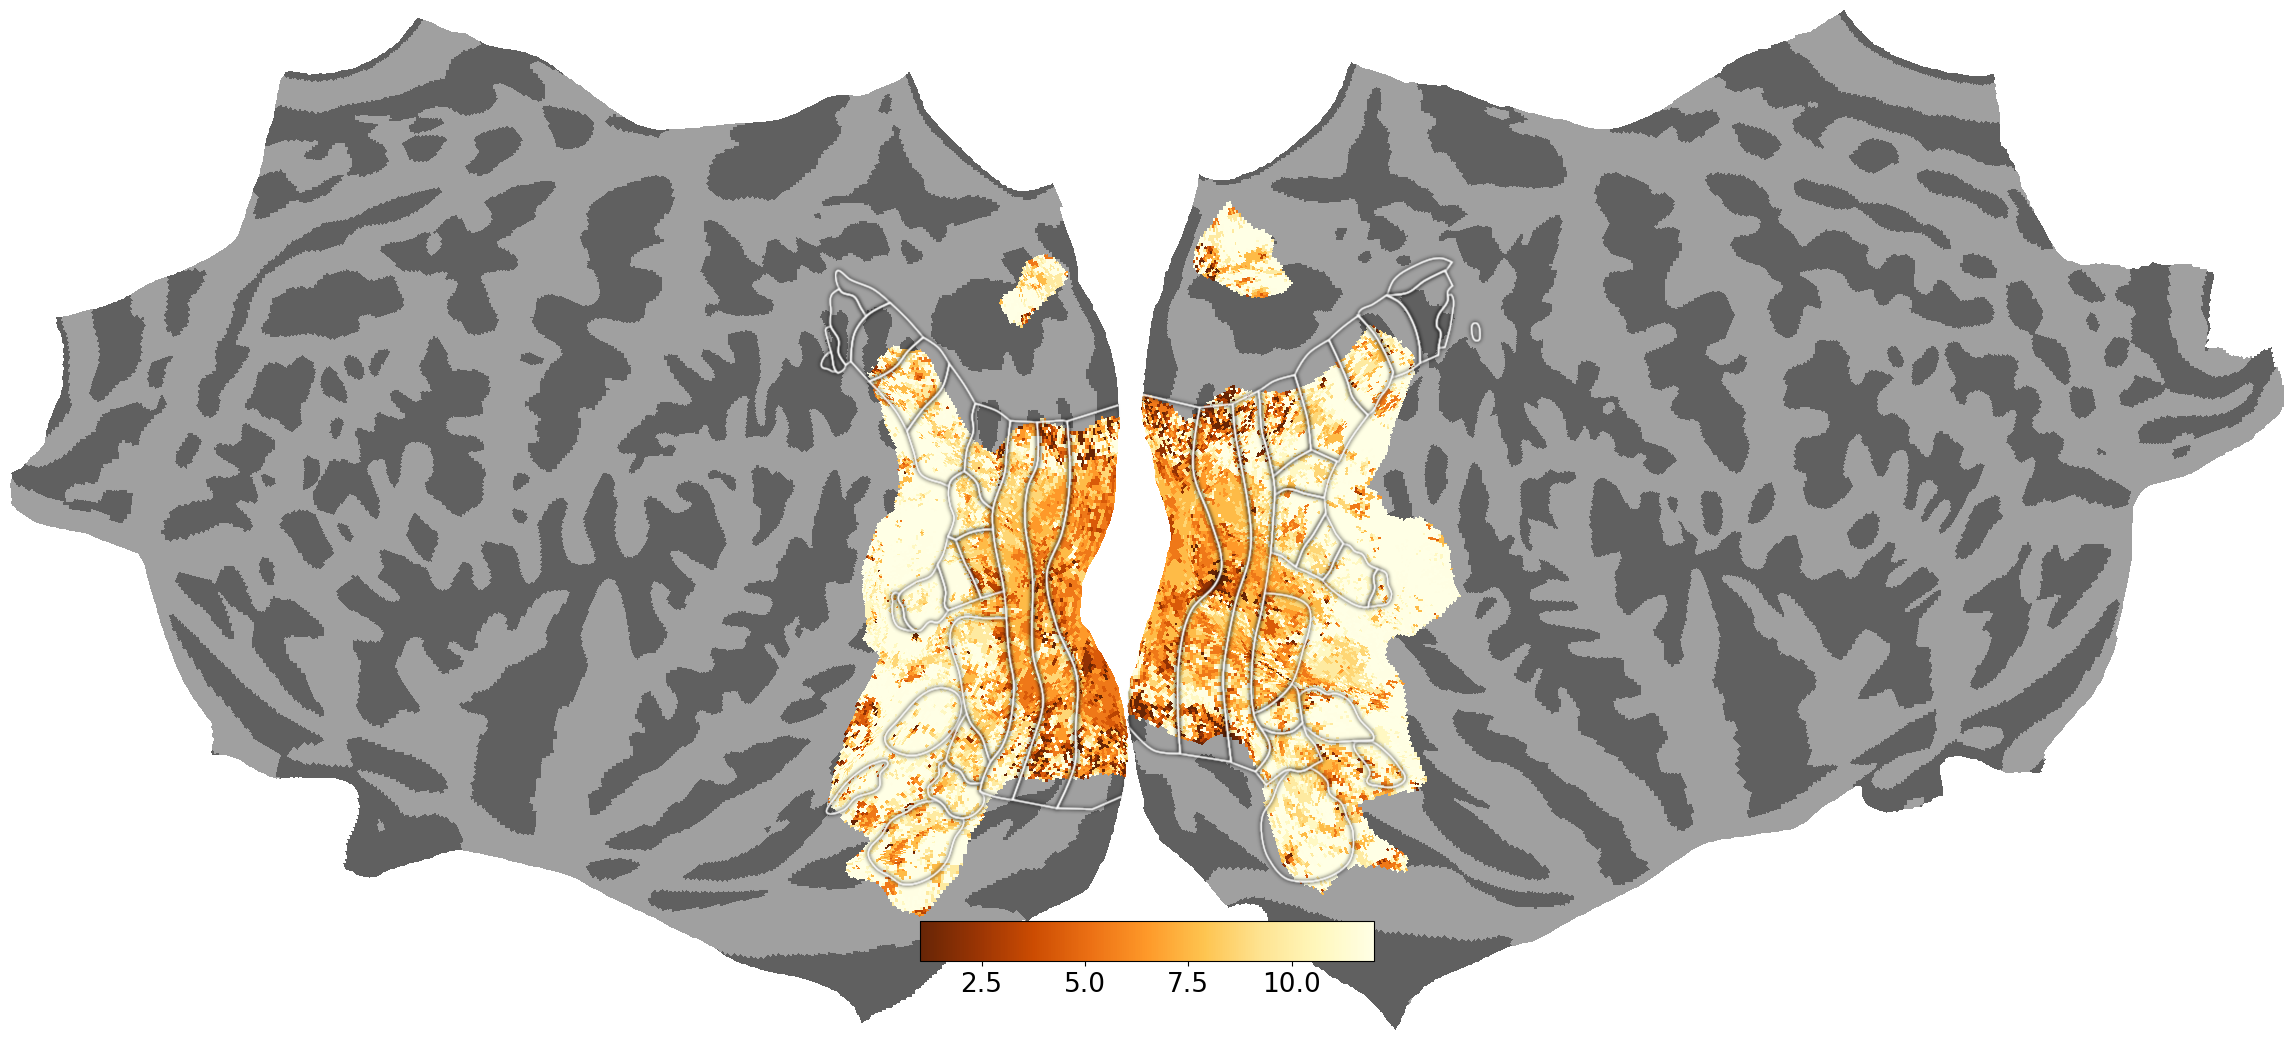

In [24]:
"""Plot data on a flattened brain surface using pycortex.

"""

import os
from copy import copy
import numpy as np
from matplotlib import pyplot as plt
import cortex
import cortex.polyutils

# =============================================================================
# Map the data to fsaverage space
# =============================================================================
# pycortex requires data in fsaverage space, so here you map the vertices from
# Challenge space into fsaverage space. The voxels not used in the Challenge
# are given NaN values, so that pycortex ignores them for the plotting.
# "ls_scores" and "rh_scores" are lists with 8 elements, one for each subject.
# These elements consist of vectors of length N, where N is the vertex amount
# for each subject and hemisphere, and each vector component consists of the
# prediction accuracy for that vertex.

#challenge_data_dir = '../algonauts_2023_challenge_data'
challenge_data_dir = '/engram/nklab/algonauts/algonauts_2023_challenge_data/'
lh_fsaverage = []
rh_fsaverage = []
subjects = [1]
for s, sub in enumerate(subjects):
    lh_mask_dir = os.path.join(challenge_data_dir, 'subj'+format(sub, '02'),
        'roi_masks', 'lh.all-vertices_fsaverage_space.npy')
    rh_mask_dir = os.path.join(challenge_data_dir, 'subj'+format(sub, '02'),
        'roi_masks', 'rh.all-vertices_fsaverage_space.npy')
    lh_fsaverage_all_vertices = np.load(lh_mask_dir)
    rh_fsaverage_all_vertices = np.load(rh_mask_dir)
    lh_fsavg = np.empty((len(lh_fsaverage_all_vertices)))
    lh_fsavg[:] = np.nan
    lh_fsavg[np.where(lh_fsaverage_all_vertices)[0]] = lh_correlation_argmax #lh_scores[s]
    lh_fsaverage.append(copy(lh_fsavg))
    rh_fsavg = np.empty((len(rh_fsaverage_all_vertices)))
    rh_fsavg[:] = np.nan
    rh_fsavg[np.where(rh_fsaverage_all_vertices)[0]] = rh_correlation_argmax #rh_scores[s]
    rh_fsaverage.append(copy(rh_fsavg))
    
    break

# Average the scores across subjects
lh_fsaverage = np.nanmean(lh_fsaverage, 0)
rh_fsaverage = np.nanmean(rh_fsaverage, 0)


# =============================================================================
# Plot parameters for colorbar
# =============================================================================
plt.rc('xtick', labelsize=19)
plt.rc('ytick', labelsize=19)


# =============================================================================
# Plot the results on brain surfaces
# =============================================================================
subject = 'fsaverage'
data = np.append(lh_fsaverage, rh_fsaverage) * 13
vertex_data = cortex.Vertex(data, subject, cmap='YlOrBr_r', vmin=1, vmax=12)
cortex.quickshow(vertex_data, with_curvature=True)
plt.savefig('my_plot.png', dpi=300) 
plt.show()



100%|██████████| 20544/20544 [00:12<00:00, 1694.98it/s]


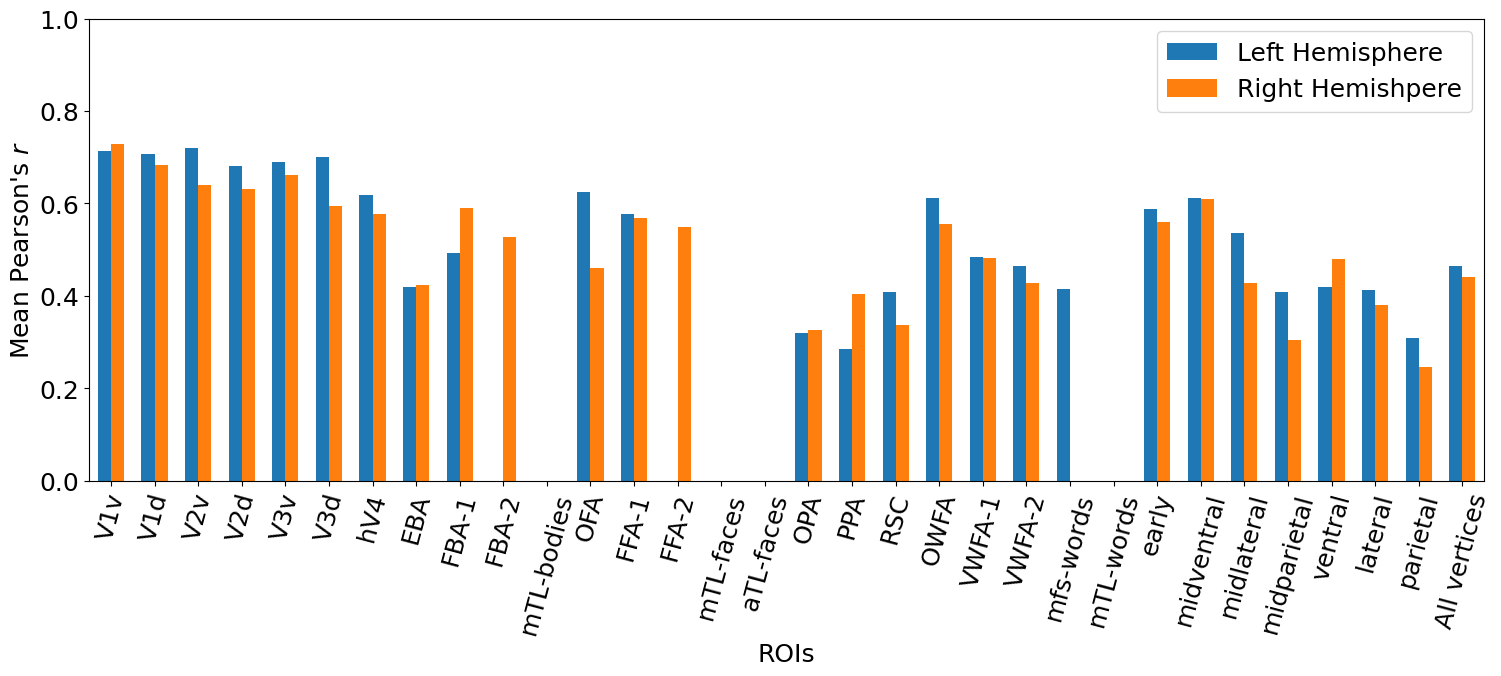

subj: 1   lh_corr: 0.46400234463228157   rh_corr: 0.44159231893153333
lh_corr_mean: 0.46400234463228157   rh_corr_mean: 0.44159231893153333


In [ ]:
lh_corr = []
rh_corr = []

verbose = 1
plot_figs = 1 

data_dir = '../../../algonauts/algonauts_2023_challenge_data/'


for subj in [1]: # range(1,9):
    
    class argObj:
        def __init__(self, data_dir, subj):

            self.subj = format(subj, '02')
            self.data_dir = os.path.join(data_dir, 'subj'+self.subj)

    args = argObj(data_dir, subj)
    
    readout_res = 'rois_all'  # [streams_inc', 'visuals', 'bodies', 'places', 'faces', 'words']
    enc_output_layer = 9
    run = 1  

    '''
    This model was trained using the following:

    python main.py --readout_res 'streams_inc' --save_model 1 --enc_output_layer 1
    '''
    lh_pred = []
    rh_pred = []
    for run in range(1, 2):
        subj_res_dir = f'./results/nsd_test/dinov2_q_transformer/subj_{args.subj}/{readout_res}/enc_{enc_output_layer}/run_{run}/'

        lh_pred.append(np.load(subj_res_dir + 'lh_pred_test.npy'))
        rh_pred.append(np.load(subj_res_dir + 'rh_pred_test.npy'))
        
    lh_fmri_pred = np.mean(lh_pred, axis=0)
    rh_fmri_pred = np.mean(rh_pred, axis=0)

    idxs = np.load(subj_res_dir + '/idxs.npy')  

    num_train = int(np.round(len(idxs) / 100 * 90))
    idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]


    fmri_dir = os.path.join(args.data_dir, 'test_split', 'test_fmri')
    lh_fmri = np.load(os.path.join(fmri_dir, 'lh_test_fmri.npy'))
    rh_fmri = np.load(os.path.join(fmri_dir, 'rh_test_fmri.npy'))

    fmri_noise_dir = os.path.join(args.data_dir, 'test_split', 'noise_ceiling')
    lh_nc = np.load(os.path.join(fmri_noise_dir, 'lh_noise_ceiling.npy'))
    rh_nc = np.load(os.path.join(fmri_noise_dir, 'rh_noise_ceiling.npy'))

    # lh_fmri_train = lh_fmri[idxs_train]
    # lh_fmri_val = lh_fmri[idxs_val]
    # rh_fmri_train = rh_fmri[idxs_train]
    # rh_fmri_val = rh_fmri[idxs_val]

    # Empty correlation array of shape: (LH vertices)
    lh_correlation = np.zeros(lh_fmri_pred.shape[1])
    # Correlate each predicted LH vertex with the corresponding ground truth vertex
    for v in tqdm(range(lh_fmri_pred.shape[1])):
        lh_correlation[v] = corr(lh_fmri_pred[:,v], lh_fmri[:,v])[0]

    # Empty correlation array of shape: (RH vertices)
    rh_correlation = np.zeros(rh_fmri_pred.shape[1])

    # Correlate each predicted RH vertex with the corresponding ground truth vertex
    for v in tqdm(range(rh_fmri_pred.shape[1])):
        rh_correlation[v] = corr(rh_fmri_pred[:,v], rh_fmri[:,v])[0]

    lh_correlation[lh_correlation<0] = 0
    rh_correlation[rh_correlation<0] = 0

    lh_r2 = lh_correlation ** 2
    rh_r2 = rh_correlation ** 2

    lh_nc[lh_nc==0] = 1e-14
    rh_nc[rh_nc==0] = 1e-14

    # Compute the noise-ceiling-normalized encoding accuracy
    expl_var_lh = np.divide(lh_r2, lh_nc)
    expl_var_rh = np.divide(rh_r2, rh_nc)

	# Set the noise-ceiling-normalized encoding accuracy to 1 for those vertices
	# in which the r2 scores are higher than the noise ceiling, to prevent
	# encoding accuracy values higher than 100%
    expl_var_lh[expl_var_lh>1] = 1
    expl_var_rh[expl_var_rh>1] = 1

    lh_correlation = expl_var_lh
    rh_correlation = expl_var_rh

    # lh_correlation = np.clip(lh_correlation / lh_noise, a_max=1, a_min=0)
    # rh_correlation = np.clip(rh_correlation / rh_noise, a_max=1, a_min=0)

    hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}

    # Load the brain surface map of all vertices
    roi_dir = os.path.join(args.data_dir, 'roi_masks',
        hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
    fsaverage_all_vertices = np.load(roi_dir)


    # Load the ROI classes mapping dictionaries
    roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
        'mapping_floc-faces.npy', 'mapping_floc-places.npy',
        'mapping_floc-words.npy', 'mapping_streams.npy']
    roi_name_maps = []
    for r in roi_mapping_files:
        roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
            allow_pickle=True).item())

    # Load the ROI brain surface maps
    lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
        'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
        'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
        'lh.streams_challenge_space.npy']
    rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
        'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
        'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
        'rh.streams_challenge_space.npy']
    lh_challenge_rois = []
    rh_challenge_rois = []
    for r in range(len(lh_challenge_roi_files)):
        lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
            lh_challenge_roi_files[r])))
        rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
            rh_challenge_roi_files[r])))

    # Select the correlation results vertices of each ROI
    roi_clusters = ['visuals', 'bodies', 'faces', 'places','words', 'streams']
    roi_names = []
    lh_roi_correlation = []
    rh_roi_correlation = []
    for r1 in range(len(lh_challenge_rois)):
        for r2 in roi_name_maps[r1].items():
            if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
                roi_names.append(r2[1])
                lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
                rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
                lh_roi_correlation.append(lh_correlation[lh_roi_idx])
                rh_roi_correlation.append(rh_correlation[rh_roi_idx])
    roi_names.append('All vertices')
    lh_roi_correlation.append(lh_correlation)
    rh_roi_correlation.append(rh_correlation)

    # Create the plot
    lh_mean_roi_correlation = [np.mean(np.nan_to_num(np.array(lh_roi_correlation[r]), copy=True, nan=0.0, posinf=None, neginf=None))
        for r in range(len(lh_roi_correlation))]
    rh_mean_roi_correlation = [np.mean(np.nan_to_num(np.array(rh_roi_correlation[r]), copy=True, nan=0.0, posinf=None, neginf=None))
        for r in range(len(rh_roi_correlation))]

    plt.rcParams.update({'font.size': 18})

    if plot_figs:
        fig = plt.figure(figsize=(18,6))
        x = np.arange(len(roi_names))
        width = 0.30
        plt.bar(x - width/2, lh_mean_roi_correlation, width, label='Left Hemisphere')
        plt.bar(x + width/2, rh_mean_roi_correlation, width,
            label='Right Hemishpere')
        plt.xlim(left=min(x)-.5, right=max(x)+.5)
        plt.ylim(bottom=0, top=1)
        plt.xlabel('ROIs')
        plt.xticks(ticks=x, labels=roi_names, rotation=75)
        plt.ylabel('Mean Pearson\'s $r$')
        plt.legend(frameon=True, loc=1);
        plt.show()
        
        #fig.savefig('figures/detr_dino_8_visuals_16.pdf', format='pdf', bbox_inches="tight")
        #fig.savefig('figures/detr_dino_1_streams_inc_16.jpg', dpi=300, bbox_inches="tight")

    lh_corr.append(lh_mean_roi_correlation[-1])
    rh_corr.append(rh_mean_roi_correlation[-1])

    if verbose:
        print(f'subj: {subj}   lh_corr: {lh_mean_roi_correlation[-1]}   rh_corr: {rh_mean_roi_correlation[-1]}')


if verbose:
    print(f'lh_corr_mean: {np.array(lh_corr).mean()}   rh_corr_mean: {np.array(rh_corr).mean()}')

In [46]:
# lh_mean_roi_correlation = np.nan_to_num(lh_mean_roi_correlation, nan=0)
# rh_mean_roi_correlation = np.nan_to_num(rh_mean_roi_correlation, nan=0)

roi_clusters = {'visuals':np.arange(0,7), 'bodies': np.arange(7,11), 'faces':np.arange(11,16), 'places':np.arange(16,19),'words':np.arange(19,24), 'streams':np.arange(24,31)}
for r in roi_clusters.keys():
    print(f'{r}: {np.nanmean(np.array(lh_mean_roi_correlation)[roi_clusters[r]])}')

visuals: 0.6896433044114972
bodies: 0.455738466378391
faces: 0.6014100926776149
places: 0.33716083088519216
words: 0.4936181463143217
streams: 0.4690869691147202


In [ ]:
for r1 in range(len(lh_challenge_rois)):
    for r2 in roi_name_maps[r1].items():
        if r2[0] != 0:
                
            lh_roi_corr_dict = {r2[0]}
            rh_roi_corr_dict = {}

lh_roi_corr_dict[r2[1]] = lh_correlation[lh_roi_idx]
                rh_roi_corr_dict[r2[1]] = rh_correlation[rh_roi_idx]

TypeError: only integer scalar arrays can be converted to a scalar index

In [24]:
for name, ind in zip(roi_names,np.arange(0, len(roi_names))):
  print(name, ind)

V1v 0
V1d 1
V2v 2
V2d 3
V3v 4
V3d 5
hV4 6
EBA 7
FBA-1 8
FBA-2 9
mTL-bodies 10
OFA 11
FFA-1 12
FFA-2 13
mTL-faces 14
aTL-faces 15
OPA 16
PPA 17
RSC 18
OWFA 19
VWFA-1 20
VWFA-2 21
mfs-words 22
mTL-words 23
early 24
midventral 25
midlateral 26
midparietal 27
ventral 28
lateral 29
parietal 30
All vertices 31


In [44]:
lh_mean_roi_correlation.shape

AttributeError: 'list' object has no attribute 'shape'